In [1]:
import pandas as pd
import numpy as np
import scipy as sc
import sklearn
import matplotlib.pyplot as plt
from sklearn.preprocessing import PowerTransformer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import umap
import seaborn as sns
from sklearn.decomposition import PCA

import tensorflow as tf
from keras.layers import Input, Dense, Lambda, Layer, Activation
from tensorflow.keras.layers import BatchNormalization
from keras.models import Model
from keras import backend as K
from keras import metrics, optimizers
from keras.callbacks import Callback
import keras
import os
import pickle5 as pickle
from keras import regularizers


import pydot
import graphviz
from keras.utils.vis_utils import plot_model
from keras_tqdm import TQDMNotebookCallback
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

import tensorflow.compat.v1.keras.backend as K
import tensorflow as tf
tf.compat.v1.disable_eager_execution()

2022-06-06 05:16:31.005258: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1


In [2]:
%matplotlib inline
plt.style.use('seaborn-notebook')

In [3]:
def transform_data(data):
    yj = PowerTransformer(method="yeo-johnson")
    return yj.fit_transform(data)

In [4]:
def generate_datasets(dataset):
    dataset.rename(columns={'Unnamed: 0':'sample'}, inplace=True)
    dataset.set_index("sample", inplace=True)
    dataset_data = dataset.iloc[:,1:]
    dataset_labels = dataset_data[["COVAR_N_status", "COVAR_M"]].copy()
    dataset_data = dataset_data.drop(["COVAR_N_status", "COVAR_M"], axis=1)
    dataset_labels_onehot = pd.DataFrame(dataset_labels["COVAR_N_status"]*2+dataset_labels["COVAR_M"])
    label_map = {0:"No LNM and no DNM", 1:"No LNM but DNM", 2:"LNM but no DM", 3:"LNM and DM"}
    dataset_labels_onehot["label"] = dataset_labels_onehot[0].map(label_map)
    dataset_labels_onehot.rename(columns={'0':'one-hot'}, inplace=True)
    dataset_scaled = pd.DataFrame(data=(StandardScaler().fit_transform(dataset_data)), columns=dataset_data.columns, index=dataset.index)
    dataset_trans = pd.DataFrame(data=transform_data(dataset_data), columns=dataset_data.columns, index=dataset.index)
    return dataset_labels, dataset_labels_onehot, dataset_data, dataset_scaled, dataset_trans

In [5]:
df2 = pd.read_csv("data/READCopyProtein50.csv")
with open('data/df2.pickle', 'wb') as f:
    pickle.dump(generate_datasets(df2), f)

In [10]:
df3 = pd.read_csv("data/COADCopyProtein50.csv")
with open('data/df3.pickle', 'wb') as f:
    pickle.dump(generate_datasets(df3), f)

In [11]:
df4 = pd.read_csv("data/GSE62254CopyConvertedProtein.csv")
with open('data/df4.pickle', 'wb') as f:
    pickle.dump(generate_datasets(df4), f)

/home/raghavgarg1000/miniconda3/envs/tybalt-gpu/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:3253: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())


In [5]:
with open('data/df2.pickle', 'rb') as f:
     df2_labels, df2_labels_onehot, df2_data, df2_scaled, df2_trans = pickle.load(f)
with open('data/df3.pickle', 'rb') as f:
     df3_labels, df3_labels_onehot, df3_data, df3_scaled, df3_trans = pickle.load(f)
with open('data/df4.pickle', 'rb') as f:
     df4_labels, df4_labels_onehot, df4_data, df4_scaled, df4_trans = pickle.load(f)

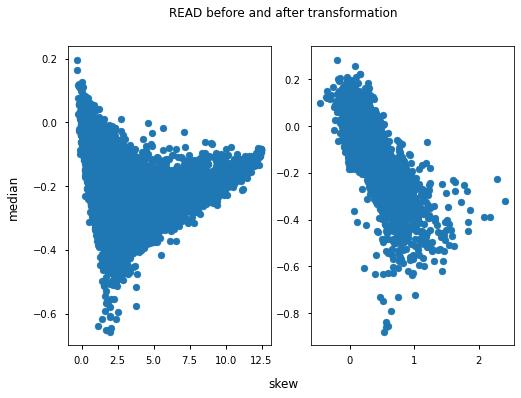

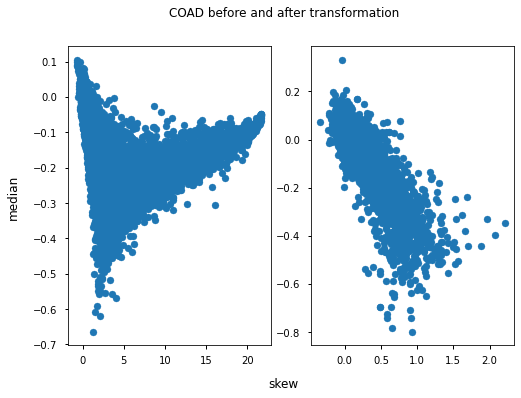

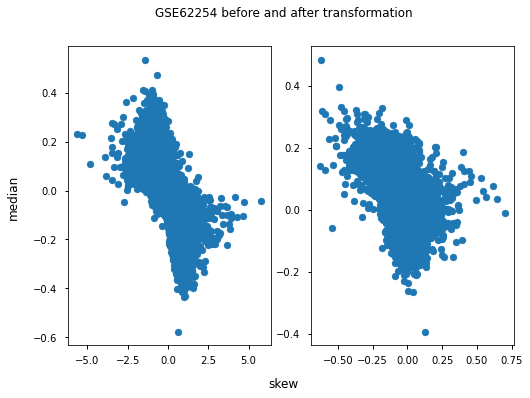

In [6]:
def get_skew(df, df_trans, name):
    skew = sc.stats.skew(df, axis=0)
    median = np.median(df, axis=0)
    skew_trans = sc.stats.skew(df_trans, axis=0)
    median_trans = np.median(df_trans, axis=0)
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.suptitle(name+' before and after transformation')
    ax1.scatter(skew, median)
    ax2.scatter(skew_trans, median_trans)
    fig.supylabel("median")
    fig.supxlabel("skew")
    plt.savefig("images/"+name+'_skew.png', bbox_inches='tight')
    plt.show()

get_skew(df2_scaled, df2_trans, "READ")
get_skew(df3_scaled, df3_trans, "COAD")
get_skew(df4_scaled, df4_trans, "GSE62254")

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


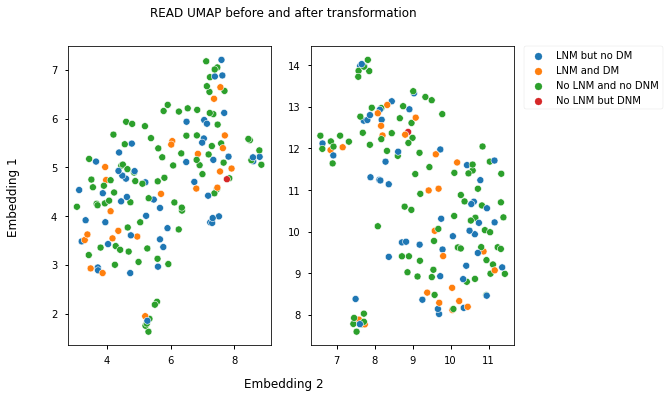

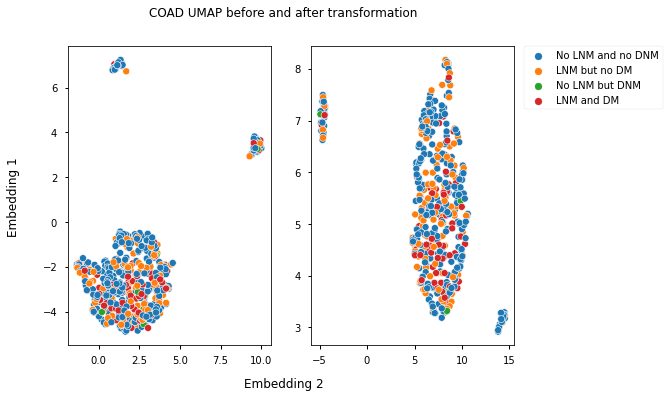

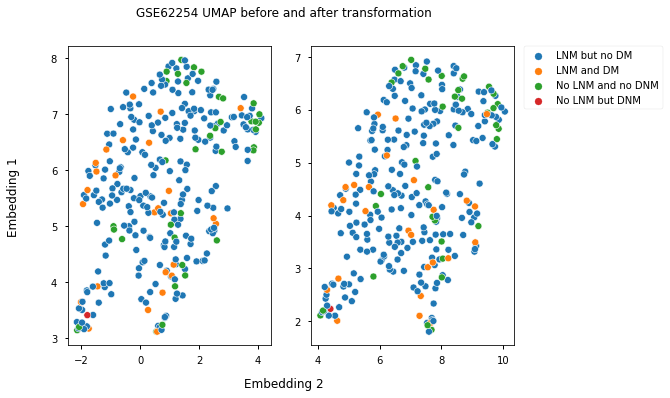

In [7]:
def get_umap(df_scaled, df_trans, data_labels_onehot, name):
    reducer = umap.UMAP()
    reducer_trans = umap.UMAP()
    
    embedding = pd.DataFrame(reducer.fit_transform(df_scaled), columns =['embedding 1', 'embedding 2'], index=data_labels_onehot.index)
    embedding = pd.concat((embedding, data_labels_onehot), axis = 1)
    embedding_trans = pd.DataFrame(reducer_trans.fit_transform(df_trans), columns =['embedding 1', 'embedding 2'], index=data_labels_onehot.index)
    embedding_trans = pd.concat((embedding_trans, data_labels_onehot), axis = 1)
    fig, (ax1, ax2) = plt.subplots(1, 2) 
    fig.suptitle(name+' UMAP before and after transformation')
    sns.scatterplot(x='embedding 1', y='embedding 2', data=embedding, ax=ax1, hue="label", legend = False)
    sns.scatterplot(x='embedding 1', y='embedding 2', data=embedding_trans, ax=ax2, hue="label")
    ax2.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)
    ax1.set(xlabel=None)
    ax1.set(ylabel=None)
    ax2.set(xlabel=None)
    ax2.set(ylabel=None)
    fig.supylabel("Embedding 1")
    fig.supxlabel("Embedding 2")
    plt.savefig("images/"+name+'_umap.png', bbox_inches='tight')
    plt.show()
    
get_umap(df2_scaled, df2_trans, df2_labels_onehot, "READ")
get_umap(df3_scaled, df3_trans, df3_labels_onehot, "COAD")
get_umap(df4_scaled, df4_trans, df4_labels_onehot, "GSE62254")

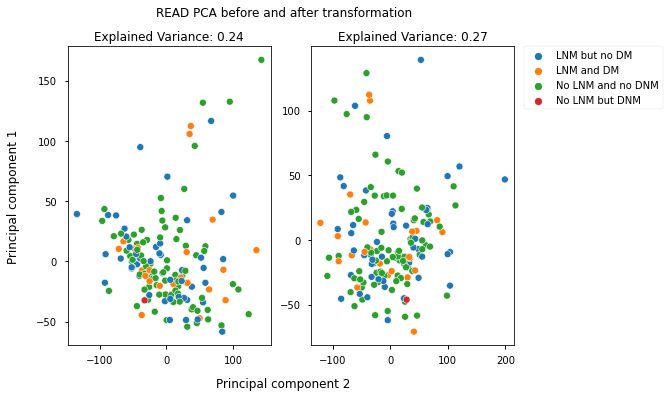

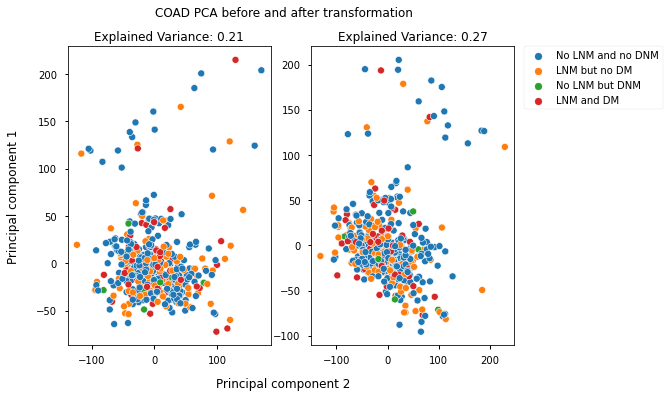

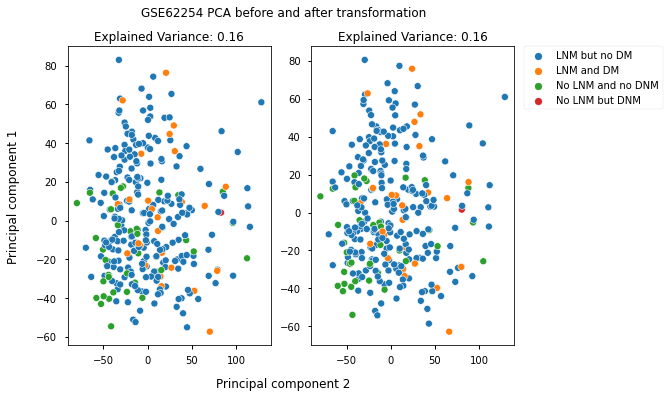

In [8]:
def get_pca(df_scaled, df_trans, data_labels_onehot, name):
    pca = PCA(n_components=2)
    pca_trans = PCA(n_components=2)
    embedding = pd.DataFrame(pca.fit_transform(df_scaled), columns = ['principal component 1', 'principal component 2'], index=data_labels_onehot.index)
    embedding_trans = pd.DataFrame(pca_trans.fit_transform(df_trans), columns = ['principal component 1', 'principal component 2'], index=data_labels_onehot.index)
    embedding = pd.concat((embedding, data_labels_onehot), axis = 1)
    embedding_trans = pd.concat((embedding_trans, data_labels_onehot), axis = 1)
    
    pca_var = PCA(n_components=20)
    pca_var_20 = sum(pca_var.fit(df_scaled).explained_variance_ratio_)
    pca_trans_var = PCA(n_components=20)
    pca_trans_var_20 = sum(pca_trans_var.fit(df_trans).explained_variance_ratio_)
    
    fig, (ax1, ax2) = plt.subplots(1, 2) 
    fig.suptitle(name+' PCA before and after transformation')
    sns.scatterplot(x='principal component 1', y='principal component 2', data=embedding, ax=ax1, hue="label", legend = False)
    sns.scatterplot(x='principal component 1', y='principal component 2', data=embedding_trans, ax=ax2, hue="label")
    ax2.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)
    ax1.set_title("Explained Variance: " + "{0:.2f}".format(sum(pca.explained_variance_ratio_[0:20])))
    ax2.set_title("Explained Variance: " + "{0:.2f}".format(sum(pca_trans.explained_variance_ratio_[0:20])))
    #ax1.set_title("Explained Variance: " + "{0:.2f}".format(pca_var_20))
    #ax2.set_title("Explained Variance: " + "{0:.2f}".format(pca_trans_var_20))
    ax1.set(xlabel=None)
    ax1.set(ylabel=None)
    ax2.set(xlabel=None)
    ax2.set(ylabel=None)
    
    fig.supylabel("Principal component 1")
    fig.supxlabel("Principal component 2")
    plt.savefig("images/"+name+'_pca.png', bbox_inches='tight')
    plt.show()
    
get_pca(df2_scaled, df2_trans, df2_labels_onehot, "READ")
get_pca(df3_scaled, df3_trans, df3_labels_onehot, "COAD")
get_pca(df4_scaled, df4_trans, df4_labels_onehot, "GSE62254")

In [6]:
test_set_percent = 0.2
df2_test_df = df2_trans.sample(frac=test_set_percent)
df2_train_df = df2_trans.drop(df2_test_df.index)

In [7]:
# Set hyper parameters
original_dim = df2_trans.shape[1]
latent_dim = 100

epsilon_std = 1.0
beta = K.variable(0)
kappa = 1.0

In [8]:
def scheduler(epoch, lr):
    if epoch < 250:
        return lr
    else:
        return lr * tf.math.exp(-0.1)
def sampling(args):
    import tensorflow as tf
    # Function with args required for Keras Lambda function
    z_mean, z_log_var = args

    # Draw epsilon of the same shape from a standard normal distribution
    epsilon = K.random_normal(shape=tf.shape(z_mean), mean=0.,
                              stddev=epsilon_std)
    
    # The latent vector is non-deterministic and differentiable
    # in respect to z_mean and z_log_var
    z = z_mean + K.exp(z_log_var / 2) * epsilon
    return z

            
class CustomVariationalLayer(Layer):
    """
    Define a custom layer that learns and performs the training
    This function is borrowed from:
    https://github.com/fchollet/keras/blob/master/examples/variational_autoencoder.py
    """
    def __init__(self, **kwargs):
        # https://keras.io/layers/writing-your-own-keras-layers/
        self.is_placeholder = True
#         self.var_layer = var_layer
#         self.mean_layer = mean_layer
        super(CustomVariationalLayer, self).__init__(**kwargs)

    def vae_loss(self, x_input, x_decoded):
        #reconstruction_loss = original_dim * metrics.binary_crossentropy(x_input, x_decoded)
        reconstruction_loss = original_dim * metrics.mse(x_input, x_decoded)
        kl_loss = - 0.5 * K.sum(1 + z_log_var_encoded - K.square(z_mean_encoded) - 
                                K.exp(z_log_var_encoded), axis=-1)
        return K.mean(reconstruction_loss + (K.get_value(beta) * kl_loss))

    def call(self, inputs):
        x = inputs[0]
        x_decoded = inputs[1]
        loss = self.vae_loss(x, x_decoded)
        self.add_loss(loss, inputs=inputs)
        # We won't actually use the output.
        return x
    
class WarmUpCallback(Callback):
    def __init__(self, beta, kappa):
        self.beta = beta
        self.kappa = kappa
    # Behavior on each epoch
    def on_epoch_end(self, epoch, logs={}):
        if K.get_value(self.beta) <= 1:
            K.set_value(self.beta, K.get_value(self.beta) + self.kappa)

# Input place holder for RNAseq data with specific input size
rnaseq_input = Input(shape=(original_dim, ))

# Input layer is compressed into a mean and log variance vector of size `latent_dim`
# Each layer is initialized with glorot uniform weights and each step (dense connections,
# batch norm, and relu activation) are funneled separately
# Each vector of length `latent_dim` are connected to the rnaseq input tensor

#z_mean_dense_linear = Dense(latent_dim, kernel_initializer='glorot_uniform', kernel_regularizer=regularizers.L1L2(l1=l1_val, l2=l2_val))(rnaseq_input)
z_mean_dense_linear = Dense(latent_dim, kernel_initializer='glorot_uniform')(rnaseq_input)
z_mean_dense_batchnorm = BatchNormalization()(z_mean_dense_linear)
z_mean_encoded = Activation('relu')(z_mean_dense_batchnorm)

#z_log_var_dense_linear = Dense(latent_dim, kernel_initializer='glorot_uniform', kernel_regularizer=regularizers.L1L2(l1=l1_val, l2=l2_val))(rnaseq_input)
z_log_var_dense_linear = Dense(latent_dim, kernel_initializer='glorot_uniform')(rnaseq_input)
z_log_var_dense_batchnorm = BatchNormalization()(z_log_var_dense_linear)
z_log_var_encoded = Activation('relu')(z_log_var_dense_batchnorm)

# return the encoded and randomly sampled z vector
# Takes two keras layers as input to the custom sampling function layer with a `latent_dim` output
z = Lambda(sampling, output_shape=(latent_dim, ))([z_mean_encoded, z_log_var_encoded])

# The decoding layer is much simpler with a single layer and sigmoid activation

#decoder_to_reconstruct = Dense(original_dim, kernel_initializer='glorot_uniform', activation='sigmoid', kernel_regularizer=regularizers.L1L2(l1=l1_val, l2=l2_val))
decoder_to_reconstruct = Dense(original_dim, kernel_initializer='glorot_uniform', activation='sigmoid')
rnaseq_reconstruct = decoder_to_reconstruct(z)

2022-06-06 05:17:05.753469: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2022-06-06 05:17:05.754563: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2022-06-06 05:17:07.719403: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:941] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-06 05:17:07.720407: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:00:04.0 name: Tesla K80 computeCapability: 3.7
coreClock: 0.8235GHz coreCount: 13 deviceMemorySize: 11.17GiB deviceMemoryBandwidth: 223.96GiB/s
2022-06-06 05:17:07.720455: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1
2022-06-06 05:17:07.722576: I tensorflow/stream_executor/platform/default/dso_lo

In [9]:
learning_rate = 0.0005
adam = optimizers.Adam(lr=learning_rate)
vae_layer = CustomVariationalLayer()([rnaseq_input, rnaseq_reconstruct])
vae = Model(rnaseq_input, vae_layer)
vae.compile(optimizer=adam, loss=None, loss_weights=[beta])
schedule = tf.keras.callbacks.LearningRateScheduler(scheduler)
stopping = tf.keras.callbacks.EarlyStopping(monitor="val_loss",min_delta=0,patience=75,verbose=0,mode="auto",baseline=None,restore_best_weights=True,)

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


2022-06-06 05:17:58.353480: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-06-06 05:17:58.353854: I tensorflow/compiler/jit/xla_gpu_device.cc:99] Not creating XLA devices, tf_xla_enable_xla_devices not set
2022-06-06 05:17:58.354317: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:941] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-06 05:17:58.355369: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:00:04.0 name: Tesla K80 computeCapability: 3.7
coreClock: 0.8235GHz coreCount: 13 deviceMemorySize: 11.17GiB deviceMemoryBandwidth: 223.96GiB/s
2022-06

2022-06-06 05:17:58.831970: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1261] Device interconnect StreamExecutor with strength 1 edge matrix:
2022-06-06 05:17:58.832037: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1267]      0 
2022-06-06 05:17:58.832055: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1280] 0:   N 
2022-06-06 05:17:58.832398: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:941] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-06 05:17:58.833473: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:941] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-06 05:17:58.834368: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:941] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-

In [10]:
batch_size = 8
epochs = 10000

hist = vae.fit(np.array(df2_train_df),
               shuffle=True,
               epochs=epochs,
               verbose=1,
               batch_size=batch_size,
               validation_data=(np.array(df2_test_df), None),
               callbacks=[schedule, stopping, WarmUpCallback(beta, kappa)])#,
                          #TQDMCallback(verbose=2)])

Train on 127 samples, validate on 32 samples
Epoch 1/10000
 72/127 [================>.............] - ETA: 0s - loss: 19392.1429

2022-06-06 05:18:27.544033: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.10


127/127 [==============================] - 1s 4ms/sample - loss: 19964.4522 - val_loss: 19644.8335
Epoch 2/10000
  8/127 [>.............................] - ETA: 0s - loss: 20013.2402

/home/raghavgarg1000/miniconda3/envs/tybalt-gpu/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:2325: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


127/127 [==============================] - 0s 1ms/sample - loss: 19124.4253 - val_loss: 17986.6982
Epoch 3/10000
127/127 [==============================] - 0s 913us/sample - loss: 18231.0671 - val_loss: 17540.4568
Epoch 4/10000
127/127 [==============================] - 0s 902us/sample - loss: 17718.7835 - val_loss: 17609.5767
Epoch 5/10000
127/127 [==============================] - 0s 915us/sample - loss: 17334.3222 - val_loss: 17138.9141
Epoch 6/10000
127/127 [==============================] - 0s 900us/sample - loss: 16828.5171 - val_loss: 17361.2205
Epoch 7/10000
127/127 [==============================] - 0s 916us/sample - loss: 16666.0001 - val_loss: 16862.9165
Epoch 8/10000
127/127 [==============================] - 0s 898us/sample - loss: 16318.8062 - val_loss: 16726.1987
Epoch 9/10000
127/127 [==============================] - 0s 915us/sample - loss: 16115.0138 - val_loss: 16527.3999
Epoch 10/10000
127/127 [==============================] - 0s 892us/sample - loss: 16012.4639 - v

Epoch 73/10000
127/127 [==============================] - 0s 877us/sample - loss: 13247.6714 - val_loss: 14310.5645
Epoch 74/10000
127/127 [==============================] - 0s 858us/sample - loss: 13245.8780 - val_loss: 14259.0244
Epoch 75/10000
127/127 [==============================] - 0s 869us/sample - loss: 13215.9248 - val_loss: 14262.4006
Epoch 76/10000
127/127 [==============================] - 0s 905us/sample - loss: 13281.7321 - val_loss: 14191.9302
Epoch 77/10000
127/127 [==============================] - 0s 941us/sample - loss: 13204.2096 - val_loss: 14238.3569
Epoch 78/10000
127/127 [==============================] - 0s 934us/sample - loss: 13204.2327 - val_loss: 14170.4131
Epoch 79/10000
127/127 [==============================] - 0s 892us/sample - loss: 13214.6201 - val_loss: 14293.6450
Epoch 80/10000
127/127 [==============================] - 0s 934us/sample - loss: 13098.1143 - val_loss: 14145.8657
Epoch 81/10000
127/127 [==============================] - 0s 892us/sampl

127/127 [==============================] - 0s 859us/sample - loss: 12202.4400 - val_loss: 13737.0476
Epoch 144/10000
127/127 [==============================] - 0s 869us/sample - loss: 12222.6934 - val_loss: 13793.7510
Epoch 145/10000
127/127 [==============================] - 0s 857us/sample - loss: 12227.4015 - val_loss: 13814.4854
Epoch 146/10000
127/127 [==============================] - 0s 893us/sample - loss: 12246.4915 - val_loss: 13687.5562
Epoch 147/10000
127/127 [==============================] - 0s 871us/sample - loss: 12163.7664 - val_loss: 13716.8071
Epoch 148/10000
127/127 [==============================] - 0s 867us/sample - loss: 12185.9690 - val_loss: 13729.9763
Epoch 149/10000
127/127 [==============================] - 0s 873us/sample - loss: 12223.9866 - val_loss: 13740.0117
Epoch 150/10000
127/127 [==============================] - 0s 886us/sample - loss: 12212.9764 - val_loss: 13750.5215
Epoch 151/10000
127/127 [==============================] - 0s 891us/sample - los

127/127 [==============================] - 0s 867us/sample - loss: 11607.0309 - val_loss: 13564.7087
Epoch 214/10000
127/127 [==============================] - 0s 863us/sample - loss: 11578.9109 - val_loss: 13618.4907
Epoch 215/10000
127/127 [==============================] - 0s 895us/sample - loss: 11531.2398 - val_loss: 13538.8870
Epoch 216/10000
127/127 [==============================] - 0s 874us/sample - loss: 11569.8131 - val_loss: 13471.2427
Epoch 217/10000
127/127 [==============================] - 0s 919us/sample - loss: 11577.6285 - val_loss: 13402.4570
Epoch 218/10000
127/127 [==============================] - 0s 882us/sample - loss: 11534.6326 - val_loss: 13531.3857
Epoch 219/10000
127/127 [==============================] - 0s 892us/sample - loss: 11538.0056 - val_loss: 13444.1541
Epoch 220/10000
127/127 [==============================] - 0s 883us/sample - loss: 11556.7362 - val_loss: 13525.6748
Epoch 221/10000
127/127 [==============================] - 0s 876us/sample - los

127/127 [==============================] - 0s 909us/sample - loss: 11167.3542 - val_loss: 13401.1553
Epoch 284/10000
127/127 [==============================] - 0s 916us/sample - loss: 11267.3911 - val_loss: 13406.1482
Epoch 285/10000
127/127 [==============================] - 0s 918us/sample - loss: 11191.8414 - val_loss: 13355.7285
Epoch 286/10000
127/127 [==============================] - 0s 921us/sample - loss: 11238.2263 - val_loss: 13420.9082
Epoch 287/10000
127/127 [==============================] - 0s 907us/sample - loss: 11256.4470 - val_loss: 13428.9048
Epoch 288/10000
127/127 [==============================] - 0s 919us/sample - loss: 11209.7719 - val_loss: 13409.1279
Epoch 289/10000
127/127 [==============================] - 0s 898us/sample - loss: 11272.9362 - val_loss: 13448.8235
Epoch 290/10000
127/127 [==============================] - 0s 899us/sample - loss: 11254.3812 - val_loss: 13347.4612
Epoch 291/10000
127/127 [==============================] - 0s 903us/sample - los

127/127 [==============================] - 0s 884us/sample - loss: 11266.1225 - val_loss: 13328.8630
Epoch 354/10000
127/127 [==============================] - 0s 898us/sample - loss: 11152.3244 - val_loss: 13391.8958
Epoch 355/10000
127/127 [==============================] - 0s 869us/sample - loss: 11262.1109 - val_loss: 13388.2764
Epoch 356/10000
127/127 [==============================] - 0s 902us/sample - loss: 11178.9150 - val_loss: 13390.9114
Epoch 357/10000
127/127 [==============================] - 0s 935us/sample - loss: 11247.6472 - val_loss: 13326.1836
Epoch 358/10000
127/127 [==============================] - 0s 926us/sample - loss: 11263.6845 - val_loss: 13427.6360
Epoch 359/10000
127/127 [==============================] - 0s 912us/sample - loss: 11202.7375 - val_loss: 13364.0237
Epoch 360/10000
127/127 [==============================] - 0s 918us/sample - loss: 11223.0044 - val_loss: 13454.4768
Epoch 361/10000
127/127 [==============================] - 0s 925us/sample - los

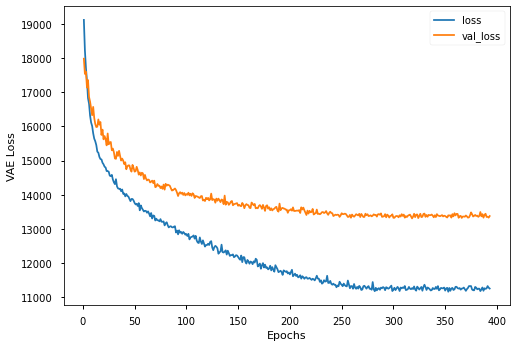

In [11]:
# Visualize training performance
history_df = pd.DataFrame(hist.history).iloc[1:,:2]
hist_plot_file = os.path.join('images', 'df2_onehidden_training.pdf')
ax = history_df.plot()
ax.set_xlabel('Epochs')
ax.set_ylabel('VAE Loss')
fig = ax.get_figure()
fig.savefig(hist_plot_file)

In [12]:
encoder = Model(rnaseq_input, z_mean_encoded)

# Encode rnaseq into the hidden/latent representation - and save output
encoded_df2_trans = encoder.predict_on_batch(df2_trans)
encoded_df2_trans = pd.DataFrame(encoded_df2_trans, index=df2_trans.index)

encoded_df2_trans.columns.name = 'sample_id'
encoded_df2_trans.columns = encoded_df2_trans.columns + 1
encoded_file = os.path.join('data', 'encoded_df2_onehidden.csv')
encoded_df2_trans.to_csv(encoded_file)

# build a generator that can sample from the learned distribution
decoder_input = Input(shape=(latent_dim, ))  # can generate from any sampled z vector
_x_decoded_mean = decoder_to_reconstruct(decoder_input)
decoder = Model(decoder_input, _x_decoded_mean)

/home/raghavgarg1000/miniconda3/envs/tybalt-gpu/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:2325: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


In [13]:
encoder_model_file = os.path.join('models', 'df2_encoder_onehidden_vae.hdf5')
decoder_model_file = os.path.join('models', 'df2_decoder_onehidden_vae.hdf5')

encoder.save(encoder_model_file)
decoder.save(decoder_model_file)

# How well does the model reconstruct the input RNAseq data
input_df2_trans_reconstruct = decoder.predict(np.array(encoded_df2_trans))
input_df2_trans_reconstruct = pd.DataFrame(input_df2_trans_reconstruct, index=df2_trans.index,
                                        columns=df2_trans.columns)
reconstruction_fidelity = df2_trans - input_df2_trans_reconstruct

gene_mean = reconstruction_fidelity.mean(axis=0)
gene_abssum = reconstruction_fidelity.abs().sum(axis=0).divide(df2_trans.shape[0])
gene_summary = pd.DataFrame([gene_mean, gene_abssum], index=['gene mean', 'gene abs(sum)']).T 
gene_summary.iloc[:,1].sum()/len(gene_summary.iloc[:,1])

0.6307085033192803

/home/raghavgarg1000/miniconda3/envs/tybalt-gpu/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


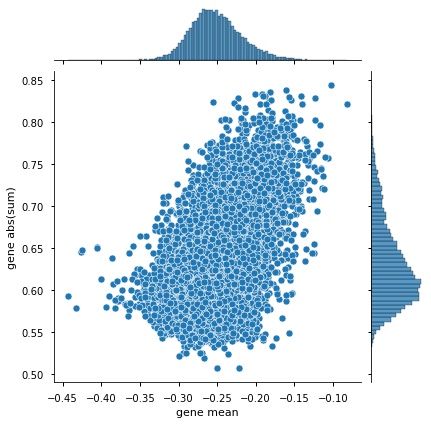

In [14]:
g = sns.jointplot('gene mean', 'gene abs(sum)', data=gene_summary)
hist_plot_file = os.path.join('images', 'df2_onehidden_reconstruction_error.png')
g.savefig(hist_plot_file)

In [22]:
test_set_percent = 0.2
df2_test_df = df2_trans.sample(frac=test_set_percent)
df2_train_df = df2_trans.drop(df2_test_df.index)

# Set hyper parameters
original_dim = df2_trans.shape[1]
latent_dim = 100
hidden_dim = 100
epsilon_std = 1.0
beta = K.variable(0)
kappa = 1.0
def scheduler(epoch, lr):
    if epoch < 250:
        return lr
    else:
        return lr * tf.math.exp(-0.1)
def sampling(args):
    import tensorflow as tf
    # Function with args required for Keras Lambda function
    z_mean, z_log_var = args

    # Draw epsilon of the same shape from a standard normal distribution
    epsilon = K.random_normal(shape=tf.shape(z_mean), mean=0.,
                              stddev=epsilon_std)
    
    # The latent vector is non-deterministic and differentiable
    # in respect to z_mean and z_log_var
    z = z_mean + K.exp(z_log_var / 2) * epsilon
    return z

            
class CustomVariationalLayer(Layer):
    """
    Define a custom layer that learns and performs the training
    This function is borrowed from:
    https://github.com/fchollet/keras/blob/master/examples/variational_autoencoder.py
    """
    def __init__(self, **kwargs):
        # https://keras.io/layers/writing-your-own-keras-layers/
        self.is_placeholder = True
        super(CustomVariationalLayer, self).__init__(**kwargs)

    def vae_loss(self, x_input, x_decoded):
        #reconstruction_loss = original_dim * metrics.binary_crossentropy(x_input, x_decoded)
        reconstruction_loss = original_dim * metrics.mse(x_input, x_decoded)
        kl_loss = - 0.5 * K.sum(1 + z_log_var_encoded - K.square(z_mean_encoded) - 
                                K.exp(z_log_var_encoded), axis=-1)
        return K.mean(reconstruction_loss + (K.get_value(beta) * kl_loss))

    def call(self, inputs):
        x = inputs[0]
        x_decoded = inputs[1]
        loss = self.vae_loss(x, x_decoded)
        self.add_loss(loss, inputs=inputs)
        # We won't actually use the output.
        return x
    
class WarmUpCallback(Callback):
    def __init__(self, beta, kappa):
        self.beta = beta
        self.kappa = kappa
    # Behavior on each epoch
    def on_epoch_end(self, epoch, logs={}):
        if K.get_value(self.beta) <= 1:
            K.set_value(self.beta, K.get_value(self.beta) + self.kappa)

# Input place holder for RNAseq data with specific input size
rnaseq_input = Input(shape=(original_dim, ))

# Input layer is compressed into a mean and log variance vector of size `latent_dim`
# Each layer is initialized with glorot uniform weights and each step (dense connections,
# batch norm, and relu activation) are funneled separately
# Each vector of length `latent_dim` are connected to the rnaseq input tensor

hidden_dense_linear = Dense(hidden_dim, kernel_initializer='glorot_uniform')(rnaseq_input)
hidden_dense_batchnorm = BatchNormalization()(hidden_dense_linear)
hidden_encoded = Activation('relu')(hidden_dense_batchnorm)

z_mean_dense_linear = Dense(latent_dim, kernel_initializer='glorot_uniform')(hidden_encoded)
z_mean_dense_batchnorm = BatchNormalization()(z_mean_dense_linear)
z_mean_encoded = Activation('relu')(z_mean_dense_batchnorm)

z_log_var_dense_linear = Dense(latent_dim, kernel_initializer='glorot_uniform')(hidden_encoded)
z_log_var_dense_batchnorm = BatchNormalization()(z_log_var_dense_linear)
z_log_var_encoded = Activation('relu')(z_log_var_dense_batchnorm)

# return the encoded and randomly sampled z vector
# Takes two keras layers as input to the custom sampling function layer with a `latent_dim` output
z = Lambda(sampling, output_shape=(latent_dim, ))([z_mean_encoded, z_log_var_encoded])

# The decoding layer is much simpler with a single layer and sigmoid activation
decoder_model = keras.Sequential()
decoder_model.add(Dense(hidden_dim, activation='relu', input_dim=latent_dim))
decoder_model.add(Dense(original_dim, activation='sigmoid'))
rnaseq_reconstruct = decoder_model(z)

In [23]:
learning_rate = 0.0005
adam = optimizers.Adam(lr=learning_rate)
vae_layer = CustomVariationalLayer()([rnaseq_input, rnaseq_reconstruct])
vae = Model(rnaseq_input, vae_layer)
vae.compile(optimizer=adam, loss=None, loss_weights=[beta])
schedule = tf.keras.callbacks.LearningRateScheduler(scheduler)
stopping = tf.keras.callbacks.EarlyStopping(monitor="val_loss",min_delta=0,patience=75,verbose=0,mode="auto",baseline=None,restore_best_weights=True,)

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


In [24]:
batch_size = 8
epochs = 1000

hist = vae.fit(np.array(df2_train_df),
               shuffle=True,
               epochs=epochs,
               verbose=1,
               batch_size=batch_size,
               validation_data=(np.array(df2_test_df), None),
               callbacks=[schedule, stopping, WarmUpCallback(beta, kappa)])#,
                          #TQDMCallback(verbose=2)])

Train on 127 samples, validate on 32 samples
Epoch 1/1000
120/127 [===========================>..] - ETA: 0s - loss: 20286.9969

/home/raghavgarg1000/miniconda3/envs/tybalt-gpu/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:2325: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


127/127 [==============================] - 1s 6ms/sample - loss: 19963.3580 - val_loss: 16853.6167
Epoch 2/1000
127/127 [==============================] - 0s 1ms/sample - loss: 18323.8123 - val_loss: 15838.5730
Epoch 3/1000
127/127 [==============================] - 0s 972us/sample - loss: 17068.6197 - val_loss: 15408.5063
Epoch 4/1000
127/127 [==============================] - 0s 1ms/sample - loss: 16471.5630 - val_loss: 15244.0435
Epoch 5/1000
127/127 [==============================] - 0s 1ms/sample - loss: 16228.9550 - val_loss: 15088.4690
Epoch 6/1000
127/127 [==============================] - 0s 1ms/sample - loss: 16021.0353 - val_loss: 15041.6074
Epoch 7/1000
127/127 [==============================] - 0s 964us/sample - loss: 15978.0308 - val_loss: 14991.7803
Epoch 8/1000
127/127 [==============================] - 0s 1ms/sample - loss: 15913.1373 - val_loss: 14890.0493
Epoch 9/1000
127/127 [==============================] - 0s 1ms/sample - loss: 15838.8127 - val_loss: 14853.3027
E

Epoch 73/1000
127/127 [==============================] - 0s 1ms/sample - loss: 13676.7118 - val_loss: 13299.2310
Epoch 74/1000
127/127 [==============================] - 0s 1ms/sample - loss: 13621.3587 - val_loss: 13176.6980
Epoch 75/1000
127/127 [==============================] - 0s 950us/sample - loss: 13698.8901 - val_loss: 13244.7227
Epoch 76/1000
127/127 [==============================] - 0s 1ms/sample - loss: 13647.6371 - val_loss: 13161.5071
Epoch 77/1000
127/127 [==============================] - 0s 940us/sample - loss: 13620.4282 - val_loss: 13233.0735
Epoch 78/1000
127/127 [==============================] - 0s 972us/sample - loss: 13509.2564 - val_loss: 13210.3801
Epoch 79/1000
127/127 [==============================] - 0s 979us/sample - loss: 13706.9091 - val_loss: 13215.1582
Epoch 80/1000
127/127 [==============================] - 0s 970us/sample - loss: 13729.6032 - val_loss: 13192.9080
Epoch 81/1000
127/127 [==============================] - 0s 976us/sample - loss: 13545

Epoch 144/1000
127/127 [==============================] - 0s 961us/sample - loss: 12912.2074 - val_loss: 12973.8337
Epoch 145/1000
127/127 [==============================] - 0s 960us/sample - loss: 12910.1104 - val_loss: 13022.7073
Epoch 146/1000
127/127 [==============================] - 0s 976us/sample - loss: 12909.3846 - val_loss: 13078.7153
Epoch 147/1000
127/127 [==============================] - 0s 1ms/sample - loss: 12920.7464 - val_loss: 13011.9688
Epoch 148/1000
127/127 [==============================] - 0s 973us/sample - loss: 12901.6684 - val_loss: 12994.3635
Epoch 149/1000
127/127 [==============================] - 0s 1ms/sample - loss: 12889.3751 - val_loss: 13088.1440
Epoch 150/1000
127/127 [==============================] - 0s 1ms/sample - loss: 12866.5903 - val_loss: 13021.5505
Epoch 151/1000
127/127 [==============================] - 0s 940us/sample - loss: 12905.5384 - val_loss: 13030.3533
Epoch 152/1000
127/127 [==============================] - 0s 948us/sample - lo

Epoch 215/1000
127/127 [==============================] - 0s 962us/sample - loss: 12387.1794 - val_loss: 12936.4944
Epoch 216/1000
127/127 [==============================] - 0s 950us/sample - loss: 12388.5588 - val_loss: 13025.8235
Epoch 217/1000
127/127 [==============================] - 0s 928us/sample - loss: 12406.8925 - val_loss: 12914.7754
Epoch 218/1000
127/127 [==============================] - 0s 922us/sample - loss: 12402.6078 - val_loss: 12916.6133
Epoch 219/1000
127/127 [==============================] - 0s 942us/sample - loss: 12334.2899 - val_loss: 13056.8452
Epoch 220/1000
127/127 [==============================] - 0s 931us/sample - loss: 12342.7114 - val_loss: 13017.3091
Epoch 221/1000
127/127 [==============================] - 0s 964us/sample - loss: 12377.0125 - val_loss: 12926.2009
Epoch 222/1000
127/127 [==============================] - 0s 956us/sample - loss: 12367.9400 - val_loss: 13057.4287
Epoch 223/1000
127/127 [==============================] - 0s 942us/sampl

Epoch 286/1000
127/127 [==============================] - 0s 985us/sample - loss: 12018.6084 - val_loss: 12897.9036
Epoch 287/1000
127/127 [==============================] - 0s 975us/sample - loss: 12083.4294 - val_loss: 12950.5791
Epoch 288/1000
127/127 [==============================] - 0s 960us/sample - loss: 11907.6600 - val_loss: 12930.2231
Epoch 289/1000
127/127 [==============================] - 0s 993us/sample - loss: 12000.6752 - val_loss: 13025.9873
Epoch 290/1000
127/127 [==============================] - 0s 975us/sample - loss: 12039.8902 - val_loss: 12972.2251
Epoch 291/1000
127/127 [==============================] - 0s 998us/sample - loss: 12013.9351 - val_loss: 12924.0710
Epoch 292/1000
127/127 [==============================] - 0s 970us/sample - loss: 12097.7225 - val_loss: 12892.3481
Epoch 293/1000
127/127 [==============================] - 0s 981us/sample - loss: 11959.9606 - val_loss: 12840.6187
Epoch 294/1000
127/127 [==============================] - 0s 1ms/sample 

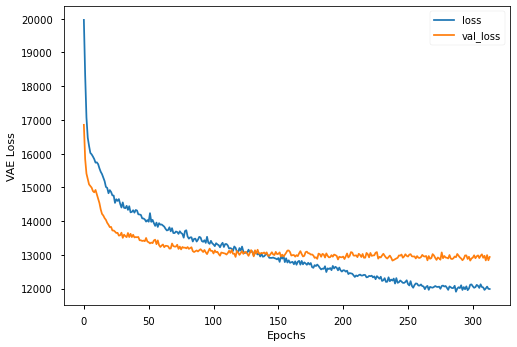

In [25]:
# Visualize training performance
history_df = pd.DataFrame(hist.history).iloc[:,:2]
hist_plot_file = os.path.join('images', 'df2_twohidden100_training.pdf')
ax = history_df.plot()
ax.set_xlabel('Epochs')
ax.set_ylabel('VAE Loss')
fig = ax.get_figure()
fig.savefig(hist_plot_file)

In [26]:
encoder = Model(rnaseq_input, z_mean_encoded)

# Encode rnaseq into the hidden/latent representation - and save output
encoded_df = encoder.predict_on_batch(df2_trans)
encoded_df = pd.DataFrame(encoded_df, index=df2_trans.index)

encoded_df.columns.name = 'sample_id'
encoded_df.columns = encoded_df.columns + 1
encoded_file = os.path.join('data', 'encoded_df2_twohidden100.csv')
encoded_df.to_csv(encoded_file)

# build a generator that can sample from the learned distribution
decoder_input = Input(shape=(latent_dim, ))  # can generate from any sampled z vector
_x_decoded_mean = decoder_model(decoder_input)
decoder = Model(decoder_input, _x_decoded_mean)

/home/raghavgarg1000/miniconda3/envs/tybalt-gpu/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:2325: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


In [27]:
encoder_model_file = os.path.join('models', 'df2_encoder_twohidden100_vae.hdf5')
decoder_model_file = os.path.join('models', 'df2_decoder_twohidden100_vae.hdf5')

encoder.save(encoder_model_file)
decoder.save(decoder_model_file)

# How well does the model reconstruct the input RNAseq data
input_df2_trans_reconstruct = decoder.predict(np.array(encoded_df))
input_df2_trans_reconstruct = pd.DataFrame(input_df2_trans_reconstruct, index=df2_trans.index,
                                        columns=df2_trans.columns)
reconstruction_fidelity = df2_trans - input_df2_trans_reconstruct

gene_mean = reconstruction_fidelity.mean(axis=0)
gene_abssum = reconstruction_fidelity.abs().sum(axis=0).divide(df2_trans.shape[0])
gene_summary = pd.DataFrame([gene_mean, gene_abssum], index=['gene mean', 'gene abs(sum)']).T
gene_summary.iloc[:,1].sum()/len(gene_summary.iloc[:,1])

0.6654205010413811

/home/raghavgarg1000/miniconda3/envs/tybalt-gpu/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


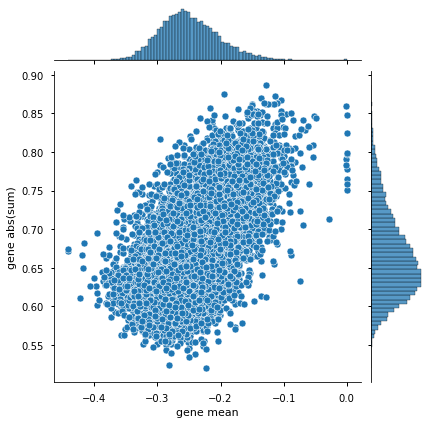

In [28]:
g = sns.jointplot('gene mean', 'gene abs(sum)', data=gene_summary)
hist_plot_file = os.path.join('images', 'df2_twohidden100_reconstruction_error.png')
g.savefig(hist_plot_file)

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Train on 379 samples, validate on 95 samples
Epoch 1/10000
379/379 [==============================] - 2s 6ms/sample - loss: 20065.6513 - val_loss: 19640.3426
Epoch 2/10000
379/379 [==============================] - 0s 993us/sample - loss: 19413.0476 - val_loss: 19023.9395
Epoch 3/10000
379/379 [==============================] - 0s 978us/sample - loss: 18856.5832 - val_loss: 18516.8134
Epoch 4/1000

379/379 [==============================] - 0s 947us/sample - loss: 14325.0765 - val_loss: 14964.2679
Epoch 62/10000
379/379 [==============================] - 0s 976us/sample - loss: 14307.8960 - val_loss: 14828.6081
Epoch 63/10000
379/379 [==============================] - 0s 974us/sample - loss: 14244.3896 - val_loss: 14805.5648
Epoch 64/10000
379/379 [==============================] - 0s 981us/sample - loss: 14271.5289 - val_loss: 14804.4856
Epoch 65/10000
379/379 [==============================] - 0s 989us/sample - loss: 14237.4832 - val_loss: 14775.3937
Epoch 66/10000
379/379 [==============================] - 0s 965us/sample - loss: 14190.4565 - val_loss: 14769.1733
Epoch 67/10000
379/379 [==============================] - 0s 988us/sample - loss: 14146.0902 - val_loss: 14707.9357
Epoch 68/10000
379/379 [==============================] - 0s 935us/sample - loss: 14145.9794 - val_loss: 14771.0531
Epoch 69/10000
379/379 [==============================] - 0s 944us/sample - loss: 14123

379/379 [==============================] - 0s 982us/sample - loss: 13346.4196 - val_loss: 13986.3926
Epoch 132/10000
379/379 [==============================] - 0s 978us/sample - loss: 13322.4072 - val_loss: 13938.5306
Epoch 133/10000
379/379 [==============================] - 0s 969us/sample - loss: 13310.0210 - val_loss: 13968.1407
Epoch 134/10000
379/379 [==============================] - 0s 972us/sample - loss: 13339.1829 - val_loss: 13953.9539
Epoch 135/10000
379/379 [==============================] - 0s 966us/sample - loss: 13342.6974 - val_loss: 13920.9156
Epoch 136/10000
379/379 [==============================] - 0s 928us/sample - loss: 13294.7793 - val_loss: 13963.1904
Epoch 137/10000
379/379 [==============================] - 0s 940us/sample - loss: 13326.5337 - val_loss: 13922.8715
Epoch 138/10000
379/379 [==============================] - 0s 974us/sample - loss: 13266.1353 - val_loss: 13884.2812
Epoch 139/10000
379/379 [==============================] - 0s 963us/sample - los

379/379 [==============================] - 0s 961us/sample - loss: 12829.7262 - val_loss: 13537.8320
Epoch 202/10000
379/379 [==============================] - 0s 989us/sample - loss: 12877.9385 - val_loss: 13514.1918
Epoch 203/10000
379/379 [==============================] - 0s 978us/sample - loss: 12826.5732 - val_loss: 13505.4072
Epoch 204/10000
379/379 [==============================] - 0s 957us/sample - loss: 12863.3886 - val_loss: 13559.5365
Epoch 205/10000
379/379 [==============================] - 0s 951us/sample - loss: 12822.7908 - val_loss: 13548.1478
Epoch 206/10000
379/379 [==============================] - 0s 973us/sample - loss: 12826.5741 - val_loss: 13521.0397
Epoch 207/10000
379/379 [==============================] - 0s 966us/sample - loss: 12848.3827 - val_loss: 13556.3452
Epoch 208/10000
379/379 [==============================] - 0s 956us/sample - loss: 12828.2854 - val_loss: 13523.9729
Epoch 209/10000
379/379 [==============================] - 0s 966us/sample - los

379/379 [==============================] - 0s 976us/sample - loss: 12514.3337 - val_loss: 13318.0162
Epoch 272/10000
379/379 [==============================] - 0s 990us/sample - loss: 12520.2696 - val_loss: 13359.3738
Epoch 273/10000
379/379 [==============================] - 0s 978us/sample - loss: 12517.5694 - val_loss: 13313.6900
Epoch 274/10000
379/379 [==============================] - 0s 969us/sample - loss: 12513.7816 - val_loss: 13298.0615
Epoch 275/10000
379/379 [==============================] - 0s 983us/sample - loss: 12563.1823 - val_loss: 13312.3129
Epoch 276/10000
379/379 [==============================] - 0s 971us/sample - loss: 12549.5047 - val_loss: 13294.9240
Epoch 277/10000
379/379 [==============================] - 0s 982us/sample - loss: 12498.9472 - val_loss: 13342.3858
Epoch 278/10000
379/379 [==============================] - 0s 993us/sample - loss: 12502.1590 - val_loss: 13279.3184
Epoch 279/10000
379/379 [==============================] - 0s 992us/sample - los

379/379 [==============================] - 0s 969us/sample - loss: 12279.4545 - val_loss: 13164.7108
Epoch 342/10000
379/379 [==============================] - 0s 961us/sample - loss: 12272.7604 - val_loss: 13106.4106
Epoch 343/10000
379/379 [==============================] - 0s 977us/sample - loss: 12285.0747 - val_loss: 13107.5526
Epoch 344/10000
379/379 [==============================] - 0s 986us/sample - loss: 12261.3288 - val_loss: 13133.8359
Epoch 345/10000
379/379 [==============================] - 1s 1ms/sample - loss: 12278.9686 - val_loss: 13104.3845
Epoch 346/10000
379/379 [==============================] - 1s 1ms/sample - loss: 12260.5581 - val_loss: 13142.0033
Epoch 347/10000
379/379 [==============================] - 0s 970us/sample - loss: 12249.3441 - val_loss: 13150.4140
Epoch 348/10000
379/379 [==============================] - 0s 961us/sample - loss: 12249.0028 - val_loss: 13176.0506
Epoch 349/10000
379/379 [==============================] - 0s 943us/sample - loss: 1

379/379 [==============================] - 0s 954us/sample - loss: 12024.9861 - val_loss: 13016.5225
Epoch 412/10000
379/379 [==============================] - 0s 964us/sample - loss: 12034.5301 - val_loss: 12967.9201
Epoch 413/10000
379/379 [==============================] - 0s 949us/sample - loss: 12072.2922 - val_loss: 12997.6078
Epoch 414/10000
379/379 [==============================] - 0s 975us/sample - loss: 12016.1255 - val_loss: 13005.1330
Epoch 415/10000
379/379 [==============================] - 0s 974us/sample - loss: 12027.5099 - val_loss: 13033.1593
Epoch 416/10000
379/379 [==============================] - 0s 985us/sample - loss: 12061.5964 - val_loss: 12966.3338
Epoch 417/10000
379/379 [==============================] - 0s 947us/sample - loss: 12038.6239 - val_loss: 12976.6803
Epoch 418/10000
379/379 [==============================] - 0s 939us/sample - loss: 11985.9123 - val_loss: 13021.9195
Epoch 419/10000
379/379 [==============================] - 0s 962us/sample - los

379/379 [==============================] - 0s 969us/sample - loss: 11894.3055 - val_loss: 12923.9625
Epoch 482/10000
379/379 [==============================] - 0s 997us/sample - loss: 11855.4652 - val_loss: 12917.4546
Epoch 483/10000
379/379 [==============================] - 0s 971us/sample - loss: 11879.8323 - val_loss: 12921.9342
Epoch 484/10000
379/379 [==============================] - 0s 973us/sample - loss: 11887.9835 - val_loss: 12885.3333
Epoch 485/10000
379/379 [==============================] - 0s 983us/sample - loss: 11888.3996 - val_loss: 12900.7123
Epoch 486/10000
379/379 [==============================] - 0s 977us/sample - loss: 11839.8950 - val_loss: 12914.7823
Epoch 487/10000
379/379 [==============================] - 0s 990us/sample - loss: 11894.3306 - val_loss: 12923.1477
Epoch 488/10000
379/379 [==============================] - 0s 961us/sample - loss: 11859.7911 - val_loss: 12920.1240
Epoch 489/10000
379/379 [==============================] - 0s 977us/sample - los

379/379 [==============================] - 0s 976us/sample - loss: 11735.8370 - val_loss: 12821.0486
Epoch 552/10000
379/379 [==============================] - 0s 970us/sample - loss: 11752.0781 - val_loss: 12800.9374
Epoch 553/10000
379/379 [==============================] - 0s 960us/sample - loss: 11741.7524 - val_loss: 12864.1128
Epoch 554/10000
379/379 [==============================] - 0s 990us/sample - loss: 11760.2595 - val_loss: 12827.6450
Epoch 555/10000
379/379 [==============================] - 0s 959us/sample - loss: 11717.4260 - val_loss: 12879.6908
Epoch 556/10000
379/379 [==============================] - 0s 963us/sample - loss: 11723.6452 - val_loss: 12820.3389
Epoch 557/10000
379/379 [==============================] - 0s 964us/sample - loss: 11716.4805 - val_loss: 12817.6069
Epoch 558/10000
379/379 [==============================] - 0s 962us/sample - loss: 11748.7077 - val_loss: 12832.6506
Epoch 559/10000
379/379 [==============================] - 0s 1ms/sample - loss:

379/379 [==============================] - 0s 948us/sample - loss: 11669.9683 - val_loss: 12792.1242
Epoch 622/10000
379/379 [==============================] - 0s 987us/sample - loss: 11629.9381 - val_loss: 12836.1037
Epoch 623/10000
379/379 [==============================] - 0s 957us/sample - loss: 11637.6789 - val_loss: 12801.0807
Epoch 624/10000
379/379 [==============================] - 0s 952us/sample - loss: 11660.4121 - val_loss: 12805.3469
Epoch 625/10000
379/379 [==============================] - 0s 954us/sample - loss: 11665.0018 - val_loss: 12812.9067
Epoch 626/10000
379/379 [==============================] - 0s 942us/sample - loss: 11650.4910 - val_loss: 12794.9841
Epoch 627/10000
379/379 [==============================] - 0s 992us/sample - loss: 11656.0576 - val_loss: 12766.8943
Epoch 628/10000
379/379 [==============================] - 0s 956us/sample - loss: 11627.4531 - val_loss: 12798.2707
Epoch 629/10000
379/379 [==============================] - 0s 949us/sample - los

379/379 [==============================] - 0s 955us/sample - loss: 11564.2899 - val_loss: 12740.3884
Epoch 692/10000
379/379 [==============================] - 0s 946us/sample - loss: 11603.4251 - val_loss: 12758.1708
Epoch 693/10000
379/379 [==============================] - 0s 1ms/sample - loss: 11570.1618 - val_loss: 12747.1810
Epoch 694/10000
379/379 [==============================] - 0s 985us/sample - loss: 11541.0294 - val_loss: 12792.1172
Epoch 695/10000
379/379 [==============================] - 0s 988us/sample - loss: 11586.4307 - val_loss: 12765.6235
Epoch 696/10000
379/379 [==============================] - 0s 951us/sample - loss: 11553.2688 - val_loss: 12777.5509
Epoch 697/10000
379/379 [==============================] - 0s 961us/sample - loss: 11592.8101 - val_loss: 12757.4474
Epoch 698/10000
379/379 [==============================] - 0s 953us/sample - loss: 11575.1435 - val_loss: 12740.9313
Epoch 699/10000
379/379 [==============================] - 0s 952us/sample - loss:

379/379 [==============================] - 0s 927us/sample - loss: 11465.3153 - val_loss: 12731.1954
Epoch 762/10000
379/379 [==============================] - 0s 951us/sample - loss: 11451.5652 - val_loss: 12750.2755
Epoch 763/10000
379/379 [==============================] - 0s 963us/sample - loss: 11454.0239 - val_loss: 12734.0451
Epoch 764/10000
379/379 [==============================] - 0s 973us/sample - loss: 11463.7801 - val_loss: 12728.8556
Epoch 765/10000
379/379 [==============================] - 0s 968us/sample - loss: 11498.4760 - val_loss: 12712.9089
Epoch 766/10000
379/379 [==============================] - 0s 969us/sample - loss: 11488.8815 - val_loss: 12722.6933
Epoch 767/10000
379/379 [==============================] - 0s 962us/sample - loss: 11508.6811 - val_loss: 12726.6753
Epoch 768/10000
379/379 [==============================] - 0s 980us/sample - loss: 11487.4794 - val_loss: 12718.1880
Epoch 769/10000
379/379 [==============================] - 0s 943us/sample - los

379/379 [==============================] - 0s 956us/sample - loss: 11419.3052 - val_loss: 12708.8744
Epoch 832/10000
379/379 [==============================] - 0s 972us/sample - loss: 11439.8724 - val_loss: 12710.0036
Epoch 833/10000
379/379 [==============================] - 1s 2ms/sample - loss: 11440.9689 - val_loss: 12728.5661
Epoch 834/10000
379/379 [==============================] - 0s 1ms/sample - loss: 11450.0033 - val_loss: 12693.7686
Epoch 835/10000
379/379 [==============================] - 0s 963us/sample - loss: 11392.6046 - val_loss: 12704.6335
Epoch 836/10000
379/379 [==============================] - 0s 953us/sample - loss: 11389.4610 - val_loss: 12718.0719
Epoch 837/10000
379/379 [==============================] - 0s 979us/sample - loss: 11430.1775 - val_loss: 12708.5294
Epoch 838/10000
379/379 [==============================] - 0s 956us/sample - loss: 11371.1150 - val_loss: 12703.2900
Epoch 839/10000
379/379 [==============================] - 0s 970us/sample - loss: 1

379/379 [==============================] - 0s 959us/sample - loss: 11355.5511 - val_loss: 12687.0256
Epoch 902/10000
379/379 [==============================] - 0s 943us/sample - loss: 11360.7231 - val_loss: 12687.3787
Epoch 903/10000
379/379 [==============================] - 0s 937us/sample - loss: 11358.1555 - val_loss: 12681.5421
Epoch 904/10000
379/379 [==============================] - 0s 957us/sample - loss: 11355.9673 - val_loss: 12688.6678
Epoch 905/10000
379/379 [==============================] - 0s 950us/sample - loss: 11333.9613 - val_loss: 12682.8027
Epoch 906/10000
379/379 [==============================] - 0s 949us/sample - loss: 11309.5380 - val_loss: 12661.0564
Epoch 907/10000
379/379 [==============================] - 0s 951us/sample - loss: 11324.1663 - val_loss: 12698.3950
Epoch 908/10000
379/379 [==============================] - 0s 939us/sample - loss: 11351.9586 - val_loss: 12721.0071
Epoch 909/10000
379/379 [==============================] - 0s 950us/sample - los

379/379 [==============================] - 0s 952us/sample - loss: 11323.3741 - val_loss: 12676.3318
Epoch 972/10000
379/379 [==============================] - 0s 976us/sample - loss: 11327.4268 - val_loss: 12612.2549
Epoch 973/10000
379/379 [==============================] - 0s 964us/sample - loss: 11357.6967 - val_loss: 12662.9432
Epoch 974/10000
379/379 [==============================] - 0s 956us/sample - loss: 11286.6123 - val_loss: 12682.3832
Epoch 975/10000
379/379 [==============================] - 0s 958us/sample - loss: 11288.1772 - val_loss: 12681.7703
Epoch 976/10000
379/379 [==============================] - 0s 965us/sample - loss: 11317.6536 - val_loss: 12639.2398
Epoch 977/10000
379/379 [==============================] - 0s 957us/sample - loss: 11310.4161 - val_loss: 12655.8740
Epoch 978/10000
379/379 [==============================] - 0s 962us/sample - loss: 11303.8727 - val_loss: 12655.6895
Epoch 979/10000
379/379 [==============================] - 0s 953us/sample - los

Epoch 1041/10000
379/379 [==============================] - 0s 974us/sample - loss: 11299.2110 - val_loss: 12667.7038
Epoch 1042/10000
379/379 [==============================] - 0s 974us/sample - loss: 11259.1665 - val_loss: 12645.8967
Epoch 1043/10000
379/379 [==============================] - 0s 977us/sample - loss: 11280.0976 - val_loss: 12645.8610
Epoch 1044/10000
379/379 [==============================] - 0s 969us/sample - loss: 11240.8596 - val_loss: 12627.1095
Epoch 1045/10000
379/379 [==============================] - 0s 942us/sample - loss: 11273.6306 - val_loss: 12661.4464
Epoch 1046/10000
379/379 [==============================] - 0s 948us/sample - loss: 11241.4809 - val_loss: 12684.4976
Epoch 1047/10000
379/379 [==============================] - 0s 982us/sample - loss: 11243.2389 - val_loss: 12659.9600
Epoch 1048/10000
379/379 [==============================] - 0s 951us/sample - loss: 11291.5134 - val_loss: 12647.0507
Epoch 1049/10000
379/379 [==============================

379/379 [==============================] - 0s 1ms/sample - loss: 11210.2441 - val_loss: 12614.6671
Epoch 1111/10000
379/379 [==============================] - 0s 995us/sample - loss: 11224.8314 - val_loss: 12633.2327
Epoch 1112/10000
379/379 [==============================] - 0s 963us/sample - loss: 11209.3412 - val_loss: 12656.9653
Epoch 1113/10000
379/379 [==============================] - 0s 967us/sample - loss: 11205.6968 - val_loss: 12649.6936
Epoch 1114/10000
379/379 [==============================] - 0s 950us/sample - loss: 11209.9804 - val_loss: 12635.6466
Epoch 1115/10000
379/379 [==============================] - 0s 961us/sample - loss: 11233.9340 - val_loss: 12626.1103
Epoch 1116/10000
379/379 [==============================] - 0s 960us/sample - loss: 11191.1750 - val_loss: 12656.2418
Epoch 1117/10000
379/379 [==============================] - 0s 952us/sample - loss: 11193.7609 - val_loss: 12665.5536
Epoch 1118/10000
379/379 [==============================] - 0s 961us/sample

/home/raghavgarg1000/miniconda3/envs/tybalt-gpu/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:2325: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


0.6202704811529441


/home/raghavgarg1000/miniconda3/envs/tybalt-gpu/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


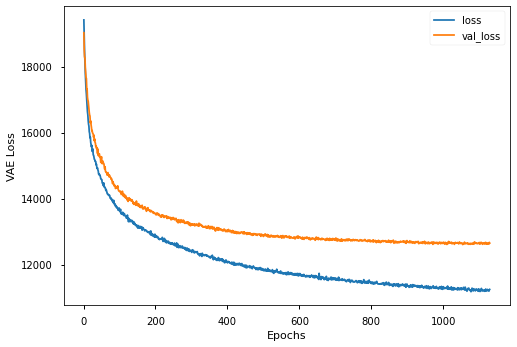

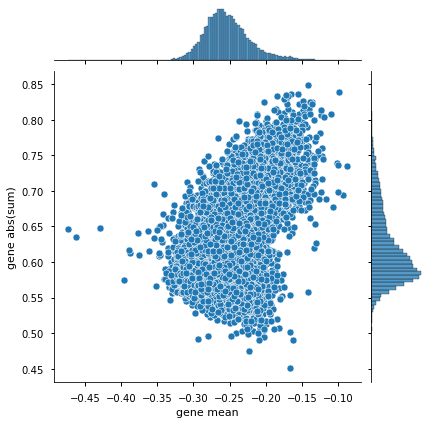

In [13]:
test_set_percent = 0.2
df2_test_df = df3_trans.sample(frac=test_set_percent)
df2_train_df = df3_trans.drop(df2_test_df.index)

# Set hyper parameters
original_dim = df3_trans.shape[1]
latent_dim = 100

epsilon_std = 1.0
beta = K.variable(0)
kappa = 1.0

def scheduler(epoch, lr):
    if epoch < 250:
        return lr
    else:
        return lr * tf.math.exp(-0.1)
def sampling(args):
    import tensorflow as tf
    # Function with args required for Keras Lambda function
    z_mean, z_log_var = args

    # Draw epsilon of the same shape from a standard normal distribution
    epsilon = K.random_normal(shape=tf.shape(z_mean), mean=0.,
                              stddev=epsilon_std)
    
    # The latent vector is non-deterministic and differentiable
    # in respect to z_mean and z_log_var
    z = z_mean + K.exp(z_log_var / 2) * epsilon
    return z

            
class CustomVariationalLayer(Layer):
    """
    Define a custom layer that learns and performs the training
    This function is borrowed from:
    https://github.com/fchollet/keras/blob/master/examples/variational_autoencoder.py
    """
    def __init__(self, **kwargs):
        # https://keras.io/layers/writing-your-own-keras-layers/
        self.is_placeholder = True
#         self.var_layer = var_layer
#         self.mean_layer = mean_layer
        super(CustomVariationalLayer, self).__init__(**kwargs)

    def vae_loss(self, x_input, x_decoded):
        #reconstruction_loss = original_dim * metrics.binary_crossentropy(x_input, x_decoded)
        reconstruction_loss = original_dim * metrics.mse(x_input, x_decoded)
        kl_loss = - 0.5 * K.sum(1 + z_log_var_encoded - K.square(z_mean_encoded) - 
                                K.exp(z_log_var_encoded), axis=-1)
        return K.mean(reconstruction_loss + (K.get_value(beta) * kl_loss))

    def call(self, inputs):
        x = inputs[0]
        x_decoded = inputs[1]
        loss = self.vae_loss(x, x_decoded)
        self.add_loss(loss, inputs=inputs)
        # We won't actually use the output.
        return x
    
class WarmUpCallback(Callback):
    def __init__(self, beta, kappa):
        self.beta = beta
        self.kappa = kappa
    # Behavior on each epoch
    def on_epoch_end(self, epoch, logs={}):
        if K.get_value(self.beta) <= 1:
            K.set_value(self.beta, K.get_value(self.beta) + self.kappa)

# Input place holder for RNAseq data with specific input size
rnaseq_input = Input(shape=(original_dim, ))

# Input layer is compressed into a mean and log variance vector of size `latent_dim`
# Each layer is initialized with glorot uniform weights and each step (dense connections,
# batch norm, and relu activation) are funneled separately
# Each vector of length `latent_dim` are connected to the rnaseq input tensor

#z_mean_dense_linear = Dense(latent_dim, kernel_initializer='glorot_uniform', kernel_regularizer=regularizers.L1L2(l1=l1_val, l2=l2_val))(rnaseq_input)
z_mean_dense_linear = Dense(latent_dim, kernel_initializer='glorot_uniform')(rnaseq_input)
z_mean_dense_batchnorm = BatchNormalization()(z_mean_dense_linear)
z_mean_encoded = Activation('relu')(z_mean_dense_batchnorm)

#z_log_var_dense_linear = Dense(latent_dim, kernel_initializer='glorot_uniform', kernel_regularizer=regularizers.L1L2(l1=l1_val, l2=l2_val))(rnaseq_input)
z_log_var_dense_linear = Dense(latent_dim, kernel_initializer='glorot_uniform')(rnaseq_input)
z_log_var_dense_batchnorm = BatchNormalization()(z_log_var_dense_linear)
z_log_var_encoded = Activation('relu')(z_log_var_dense_batchnorm)

# return the encoded and randomly sampled z vector
# Takes two keras layers as input to the custom sampling function layer with a `latent_dim` output
z = Lambda(sampling, output_shape=(latent_dim, ))([z_mean_encoded, z_log_var_encoded])

# The decoding layer is much simpler with a single layer and sigmoid activation

#decoder_to_reconstruct = Dense(original_dim, kernel_initializer='glorot_uniform', activation='sigmoid', kernel_regularizer=regularizers.L1L2(l1=l1_val, l2=l2_val))
decoder_to_reconstruct = Dense(original_dim, kernel_initializer='glorot_uniform', activation='sigmoid')
rnaseq_reconstruct = decoder_to_reconstruct(z)

learning_rate = 0.0001
adam = optimizers.Adam(lr=learning_rate)
vae_layer = CustomVariationalLayer()([rnaseq_input, rnaseq_reconstruct])
vae = Model(rnaseq_input, vae_layer)
vae.compile(optimizer=adam, loss=None, loss_weights=[beta])
schedule = tf.keras.callbacks.LearningRateScheduler(scheduler)
stopping = tf.keras.callbacks.EarlyStopping(monitor="val_loss",min_delta=0,patience=75,verbose=0,mode="auto",baseline=None,restore_best_weights=True,)

batch_size = 8
epochs = 10000

hist = vae.fit(np.array(df2_train_df),
               shuffle=True,
               epochs=epochs,
               verbose=1,
               batch_size=batch_size,
               validation_data=(np.array(df2_test_df), None),
               callbacks=[stopping, WarmUpCallback(beta, kappa)])#,
                          #TQDMCallback(verbose=2)])

# Visualize training performance
history_df = pd.DataFrame(hist.history).iloc[1:,:2]
hist_plot_file = os.path.join('images', 'df3_onehidden_training.pdf')
ax = history_df.plot()
ax.set_xlabel('Epochs')
ax.set_ylabel('VAE Loss')
fig = ax.get_figure()
fig.savefig(hist_plot_file)

encoder = Model(rnaseq_input, z_mean_encoded)

# Encode rnaseq into the hidden/latent representation - and save output
encoded_df2_trans = encoder.predict_on_batch(df3_trans)
encoded_df2_trans = pd.DataFrame(encoded_df2_trans, index=df3_trans.index)

encoded_df2_trans.columns.name = 'sample_id'
encoded_df2_trans.columns = encoded_df2_trans.columns + 1
encoded_file = os.path.join('data', 'encoded_df3_onehidden.csv')
encoded_df2_trans.to_csv(encoded_file)

# build a generator that can sample from the learned distribution
decoder_input = Input(shape=(latent_dim, ))  # can generate from any sampled z vector
_x_decoded_mean = decoder_to_reconstruct(decoder_input)
decoder = Model(decoder_input, _x_decoded_mean)

encoder_model_file = os.path.join('models', 'df3_encoder_onehidden_vae.hdf5')
decoder_model_file = os.path.join('models', 'df3_decoder_onehidden_vae.hdf5')

encoder.save(encoder_model_file)
decoder.save(decoder_model_file)

# How well does the model reconstruct the input RNAseq data
input_df2_trans_reconstruct = decoder.predict(np.array(encoded_df2_trans))
input_df2_trans_reconstruct = pd.DataFrame(input_df2_trans_reconstruct, index=df3_trans.index,
                                        columns=df3_trans.columns)
reconstruction_fidelity = df3_trans - input_df2_trans_reconstruct

gene_mean = reconstruction_fidelity.mean(axis=0)
gene_abssum = reconstruction_fidelity.abs().sum(axis=0).divide(df3_trans.shape[0])
gene_summary = pd.DataFrame([gene_mean, gene_abssum], index=['gene mean', 'gene abs(sum)']).T 
print(gene_summary.iloc[:,1].sum()/len(gene_summary.iloc[:,1]))

g = sns.jointplot('gene mean', 'gene abs(sum)', data=gene_summary)
hist_plot_file = os.path.join('images', 'df3_onehidden_recontruction_error.png')
g.savefig(hist_plot_file)

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Train on 379 samples, validate on 95 samples
Epoch 1/1000
379/379 [==============================] - 1s 3ms/sample - loss: 20031.7601 - val_loss: 18406.9959
Epoch 2/1000
379/379 [==============================] - 0s 990us/sample - loss: 19035.3988 - val_loss: 17497.4222
Epoch 3/1000
379/379 [==============================] - 0s 1ms/sample - loss: 17992.6979 - val_loss: 16687.8680
Epoch 4/1000
379/

Epoch 63/1000
379/379 [==============================] - 0s 995us/sample - loss: 14246.3370 - val_loss: 13679.7462
Epoch 64/1000
379/379 [==============================] - 0s 1ms/sample - loss: 14257.6978 - val_loss: 13653.5904
Epoch 65/1000
379/379 [==============================] - 0s 991us/sample - loss: 14306.8651 - val_loss: 13656.2633
Epoch 66/1000
379/379 [==============================] - 0s 1000us/sample - loss: 14211.4715 - val_loss: 13637.9920
Epoch 67/1000
379/379 [==============================] - 0s 1ms/sample - loss: 14215.4057 - val_loss: 13603.2948
Epoch 68/1000
379/379 [==============================] - 0s 1ms/sample - loss: 14235.4507 - val_loss: 13557.8341
Epoch 69/1000
379/379 [==============================] - 0s 1ms/sample - loss: 14166.4378 - val_loss: 13574.1697
Epoch 70/1000
379/379 [==============================] - 0s 1ms/sample - loss: 14139.9261 - val_loss: 13553.5399
Epoch 71/1000
379/379 [==============================] - 0s 1ms/sample - loss: 14159.5818

379/379 [==============================] - 0s 1ms/sample - loss: 13599.5666 - val_loss: 13083.5864
Epoch 136/1000
379/379 [==============================] - 0s 1ms/sample - loss: 13570.3259 - val_loss: 13061.9375
Epoch 137/1000
379/379 [==============================] - 0s 1ms/sample - loss: 13552.5568 - val_loss: 13054.4049
Epoch 138/1000
379/379 [==============================] - 0s 1ms/sample - loss: 13554.3989 - val_loss: 13067.8780
Epoch 139/1000
379/379 [==============================] - 0s 1ms/sample - loss: 13612.2532 - val_loss: 13093.1758
Epoch 140/1000
379/379 [==============================] - 0s 1ms/sample - loss: 13562.1397 - val_loss: 13029.5943
Epoch 141/1000
379/379 [==============================] - 0s 1ms/sample - loss: 13596.7724 - val_loss: 13077.8110
Epoch 142/1000
379/379 [==============================] - 0s 1ms/sample - loss: 13555.2763 - val_loss: 13060.1871
Epoch 143/1000
379/379 [==============================] - 0s 1ms/sample - loss: 13594.6661 - val_loss: 

Epoch 207/1000
379/379 [==============================] - 0s 1ms/sample - loss: 13270.0276 - val_loss: 12935.8328
Epoch 208/1000
379/379 [==============================] - 0s 1ms/sample - loss: 13270.4390 - val_loss: 12893.7976
Epoch 209/1000
379/379 [==============================] - 0s 1ms/sample - loss: 13267.1314 - val_loss: 12937.7014
Epoch 210/1000
379/379 [==============================] - 0s 1ms/sample - loss: 13297.7102 - val_loss: 12914.1975
Epoch 211/1000
379/379 [==============================] - 0s 1ms/sample - loss: 13243.6800 - val_loss: 12938.5784
Epoch 212/1000
379/379 [==============================] - 0s 1ms/sample - loss: 13303.1186 - val_loss: 12926.7414
Epoch 213/1000
379/379 [==============================] - 0s 1ms/sample - loss: 13307.7464 - val_loss: 12877.7609
Epoch 214/1000
379/379 [==============================] - 0s 1ms/sample - loss: 13224.6035 - val_loss: 12905.3837
Epoch 215/1000
379/379 [==============================] - 0s 1ms/sample - loss: 13269.66

Epoch 279/1000
379/379 [==============================] - 0s 1ms/sample - loss: 13279.8238 - val_loss: 12908.9795
Epoch 280/1000
379/379 [==============================] - 0s 1ms/sample - loss: 13276.7943 - val_loss: 12896.6978
Epoch 281/1000
379/379 [==============================] - 0s 993us/sample - loss: 13266.7713 - val_loss: 12915.1384
Epoch 282/1000
379/379 [==============================] - 0s 1ms/sample - loss: 13250.1859 - val_loss: 12874.0340
Epoch 283/1000
379/379 [==============================] - 0s 1ms/sample - loss: 13300.8324 - val_loss: 12876.3895
Epoch 284/1000
379/379 [==============================] - 0s 1ms/sample - loss: 13248.2109 - val_loss: 12900.8022
Epoch 285/1000
379/379 [==============================] - 0s 1ms/sample - loss: 13230.1321 - val_loss: 12924.8104
Epoch 286/1000
379/379 [==============================] - 0s 1ms/sample - loss: 13243.6819 - val_loss: 12884.5368
Epoch 287/1000
379/379 [==============================] - 0s 1ms/sample - loss: 13275.

Epoch 351/1000
379/379 [==============================] - 0s 1ms/sample - loss: 13257.1174 - val_loss: 12886.9588
Epoch 352/1000
379/379 [==============================] - 0s 1ms/sample - loss: 13284.7921 - val_loss: 12885.9490
Epoch 353/1000
379/379 [==============================] - 0s 1ms/sample - loss: 13270.1582 - val_loss: 12894.2942
Epoch 354/1000
379/379 [==============================] - 0s 1ms/sample - loss: 13294.8436 - val_loss: 12871.9698
Epoch 355/1000
379/379 [==============================] - 0s 1ms/sample - loss: 13200.6499 - val_loss: 12900.2418
Epoch 356/1000
379/379 [==============================] - 0s 1ms/sample - loss: 13310.4845 - val_loss: 12896.5870
Epoch 357/1000
379/379 [==============================] - 0s 1ms/sample - loss: 13229.2873 - val_loss: 12924.1849
Epoch 358/1000
379/379 [==============================] - 0s 1ms/sample - loss: 13310.5401 - val_loss: 12891.2978
Epoch 359/1000
379/379 [==============================] - 0s 1ms/sample - loss: 13242.68

Epoch 423/1000
379/379 [==============================] - 0s 1ms/sample - loss: 13292.4752 - val_loss: 12889.1829
Epoch 424/1000
379/379 [==============================] - 0s 1ms/sample - loss: 13287.9253 - val_loss: 12905.6467
Epoch 425/1000
379/379 [==============================] - 0s 1ms/sample - loss: 13222.5393 - val_loss: 12871.8852
Epoch 426/1000
379/379 [==============================] - 0s 1ms/sample - loss: 13303.4562 - val_loss: 12910.6931
Epoch 427/1000
379/379 [==============================] - 0s 1ms/sample - loss: 13272.4875 - val_loss: 12882.7079
Epoch 428/1000
379/379 [==============================] - 0s 1ms/sample - loss: 13247.7333 - val_loss: 12897.9032
Epoch 429/1000
379/379 [==============================] - 0s 1ms/sample - loss: 13219.7017 - val_loss: 12952.5363
Epoch 430/1000
379/379 [==============================] - 0s 1ms/sample - loss: 13265.1143 - val_loss: 12916.8389
Epoch 431/1000
379/379 [==============================] - 0s 1ms/sample - loss: 13269.14

Epoch 495/1000
379/379 [==============================] - 0s 1ms/sample - loss: 13265.7495 - val_loss: 12879.0583
Epoch 496/1000
379/379 [==============================] - 0s 1ms/sample - loss: 13279.7738 - val_loss: 12885.0470
Epoch 497/1000
379/379 [==============================] - 0s 1ms/sample - loss: 13252.5932 - val_loss: 12882.5570
Epoch 498/1000
379/379 [==============================] - 0s 1ms/sample - loss: 13247.9661 - val_loss: 12895.2605
Epoch 499/1000
379/379 [==============================] - 0s 1ms/sample - loss: 13234.7118 - val_loss: 12888.0267
Epoch 500/1000
379/379 [==============================] - 0s 1ms/sample - loss: 13290.7460 - val_loss: 12944.5817
Epoch 501/1000
379/379 [==============================] - 0s 1ms/sample - loss: 13232.9986 - val_loss: 12872.8945
Epoch 502/1000
379/379 [==============================] - 0s 1ms/sample - loss: 13240.6007 - val_loss: 12879.1638
Epoch 503/1000
379/379 [==============================] - 0s 1ms/sample - loss: 13254.56

/home/raghavgarg1000/miniconda3/envs/tybalt-gpu/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:2325: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


0.6912116661743644


/home/raghavgarg1000/miniconda3/envs/tybalt-gpu/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


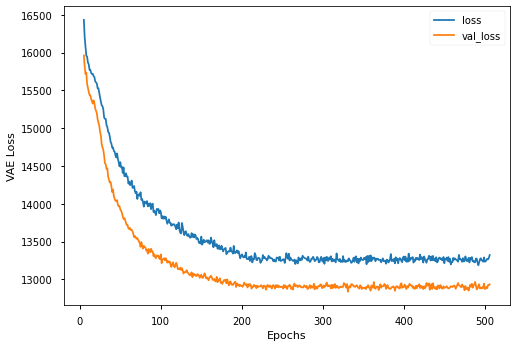

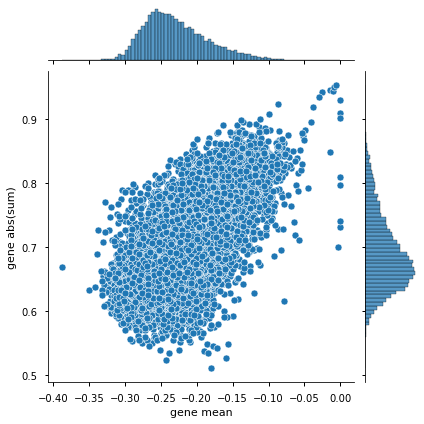

In [10]:
test_set_percent = 0.2
df2_test_df = df3_trans.sample(frac=test_set_percent)
df2_train_df = df3_trans.drop(df2_test_df.index)

# Set hyper parameters
original_dim = df3_trans.shape[1]
latent_dim = 100
hidden_dim = 100
epsilon_std = 1.0
beta = K.variable(0)
kappa = 1.0

def scheduler(epoch, lr):
    if epoch < 200:
        return lr
    else:
        return lr * tf.math.exp(-0.1)
def sampling(args):
    import tensorflow as tf
    # Function with args required for Keras Lambda function
    z_mean, z_log_var = args

    # Draw epsilon of the same shape from a standard normal distribution
    epsilon = K.random_normal(shape=tf.shape(z_mean), mean=0.,
                              stddev=epsilon_std)
    
    # The latent vector is non-deterministic and differentiable
    # in respect to z_mean and z_log_var
    z = z_mean + K.exp(z_log_var / 2) * epsilon
    return z

            
class CustomVariationalLayer(Layer):
    """
    Define a custom layer that learns and performs the training
    This function is borrowed from:
    https://github.com/fchollet/keras/blob/master/examples/variational_autoencoder.py
    """
    def __init__(self, **kwargs):
        # https://keras.io/layers/writing-your-own-keras-layers/
        self.is_placeholder = True
        super(CustomVariationalLayer, self).__init__(**kwargs)

    def vae_loss(self, x_input, x_decoded):
        #reconstruction_loss = original_dim * metrics.binary_crossentropy(x_input, x_decoded)
        reconstruction_loss = original_dim * metrics.mse(x_input, x_decoded)
        kl_loss = - 0.5 * K.sum(1 + z_log_var_encoded - K.square(z_mean_encoded) - 
                                K.exp(z_log_var_encoded), axis=-1)
        return K.mean(reconstruction_loss + (K.get_value(beta) * kl_loss))

    def call(self, inputs):
        x = inputs[0]
        x_decoded = inputs[1]
        loss = self.vae_loss(x, x_decoded)
        self.add_loss(loss, inputs=inputs)
        # We won't actually use the output.
        return x
    
class WarmUpCallback(Callback):
    def __init__(self, beta, kappa):
        self.beta = beta
        self.kappa = kappa
    # Behavior on each epoch
    def on_epoch_end(self, epoch, logs={}):
        if K.get_value(self.beta) <= 1:
            K.set_value(self.beta, K.get_value(self.beta) + self.kappa)

# Input place holder for RNAseq data with specific input size
rnaseq_input = Input(shape=(original_dim, ))

# Input layer is compressed into a mean and log variance vector of size `latent_dim`
# Each layer is initialized with glorot uniform weights and each step (dense connections,
# batch norm, and relu activation) are funneled separately
# Each vector of length `latent_dim` are connected to the rnaseq input tensor

hidden_dense_linear = Dense(hidden_dim, kernel_initializer='glorot_uniform')(rnaseq_input)
hidden_dense_batchnorm = BatchNormalization()(hidden_dense_linear)
hidden_encoded = Activation('relu')(hidden_dense_batchnorm)

z_mean_dense_linear = Dense(latent_dim, kernel_initializer='glorot_uniform')(hidden_encoded)
z_mean_dense_batchnorm = BatchNormalization()(z_mean_dense_linear)
z_mean_encoded = Activation('relu')(z_mean_dense_batchnorm)

z_log_var_dense_linear = Dense(latent_dim, kernel_initializer='glorot_uniform')(hidden_encoded)
z_log_var_dense_batchnorm = BatchNormalization()(z_log_var_dense_linear)
z_log_var_encoded = Activation('relu')(z_log_var_dense_batchnorm)

# return the encoded and randomly sampled z vector
# Takes two keras layers as input to the custom sampling function layer with a `latent_dim` output
z = Lambda(sampling, output_shape=(latent_dim, ))([z_mean_encoded, z_log_var_encoded])

# The decoding layer is much simpler with a single layer and sigmoid activation
decoder_model = keras.Sequential()
decoder_model.add(Dense(hidden_dim, activation='relu', input_dim=latent_dim))
decoder_model.add(Dense(original_dim, activation='sigmoid'))
rnaseq_reconstruct = decoder_model(z)

learning_rate = 0.0001
adam = optimizers.Adam(lr=learning_rate)
vae_layer = CustomVariationalLayer()([rnaseq_input, rnaseq_reconstruct])
vae = Model(rnaseq_input, vae_layer)
vae.compile(optimizer=adam, loss=None, loss_weights=[beta])
schedule = tf.keras.callbacks.LearningRateScheduler(scheduler)
stopping = tf.keras.callbacks.EarlyStopping(monitor="val_loss",min_delta=0,patience=175,verbose=0,mode="auto",baseline=None,restore_best_weights=True,)

batch_size = 8
epochs = 1000

hist = vae.fit(np.array(df2_train_df),
               shuffle=True,
               epochs=epochs,
               verbose=1,
               batch_size=batch_size,
               validation_data=(np.array(df2_test_df), None),
               callbacks=[schedule, stopping, WarmUpCallback(beta, kappa)])#,
                          #TQDMCallback(verbose=2)])

# Visualize training performance
history_df = pd.DataFrame(hist.history).iloc[5:,:2]
hist_plot_file = os.path.join('images', 'df3_twohidden100_training.pdf')
ax = history_df.plot()
ax.set_xlabel('Epochs')
ax.set_ylabel('VAE Loss')
fig = ax.get_figure()
fig.savefig(hist_plot_file)

encoder = Model(rnaseq_input, z_mean_encoded)

# Encode rnaseq into the hidden/latent representation - and save output
encoded_df = encoder.predict_on_batch(df3_trans)
encoded_df = pd.DataFrame(encoded_df, index=df3_trans.index)

encoded_df.columns.name = 'sample_id'
encoded_df.columns = encoded_df.columns + 1
encoded_file = os.path.join('data', 'encoded_df3_twohidden100.csv')
encoded_df.to_csv(encoded_file)

# build a generator that can sample from the learned distribution
decoder_input = Input(shape=(latent_dim, ))  # can generate from any sampled z vector
_x_decoded_mean = decoder_model(decoder_input)
decoder = Model(decoder_input, _x_decoded_mean)

encoder_model_file = os.path.join('models', 'df3_encoder_twohidden100_vae.hdf5')
decoder_model_file = os.path.join('models', 'df3_decoder_twohidden100_vae.hdf5')

encoder.save(encoder_model_file)
decoder.save(decoder_model_file)

# How well does the model reconstruct the input RNAseq data
input_df2_trans_reconstruct = decoder.predict(np.array(encoded_df))
input_df2_trans_reconstruct = pd.DataFrame(input_df2_trans_reconstruct, index=df3_trans.index,
                                        columns=df3_trans.columns)
reconstruction_fidelity = df3_trans - input_df2_trans_reconstruct

gene_mean = reconstruction_fidelity.mean(axis=0)
gene_abssum = reconstruction_fidelity.abs().sum(axis=0).divide(df3_trans.shape[0])
gene_summary = pd.DataFrame([gene_mean, gene_abssum], index=['gene mean', 'gene abs(sum)']).T
print(gene_summary.iloc[:,1].sum()/len(gene_summary.iloc[:,1]))

g = sns.jointplot('gene mean', 'gene abs(sum)', data=gene_summary)
hist_plot_file = os.path.join('images', 'df3_twohidden300_recontruction_error.png')
g.savefig(hist_plot_file)

In [ ]:
### DF4

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Train on 240 samples, validate on 60 samples
Epoch 1/10000
200/240 [========================>.....] - ETA: 0s - loss: 18369.9529

/home/raghavgarg1000/miniconda3/envs/tybalt-gpu/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:2325: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


240/240 [==============================] - 3s 14ms/sample - loss: 18292.6369 - val_loss: 16991.5530
Epoch 2/10000
240/240 [==============================] - 0s 967us/sample - loss: 17303.8391 - val_loss: 16396.7438
Epoch 3/10000
240/240 [==============================] - 0s 946us/sample - loss: 16538.4789 - val_loss: 15880.0202
Epoch 4/10000
240/240 [==============================] - 0s 940us/sample - loss: 15940.1921 - val_loss: 15671.6413
Epoch 5/10000
240/240 [==============================] - 0s 943us/sample - loss: 15618.9982 - val_loss: 15415.9414
Epoch 6/10000
240/240 [==============================] - 0s 918us/sample - loss: 15216.8869 - val_loss: 15168.8923
Epoch 7/10000
240/240 [==============================] - 0s 927us/sample - loss: 15094.7066 - val_loss: 15205.5488
Epoch 8/10000
240/240 [==============================] - 0s 932us/sample - loss: 14908.9763 - val_loss: 14950.8605
Epoch 9/10000
240/240 [==============================] - 0s 929us/sample - loss: 14718.5160 - v

Epoch 72/10000
240/240 [==============================] - 0s 908us/sample - loss: 12564.9109 - val_loss: 13483.7759
Epoch 73/10000
240/240 [==============================] - 0s 915us/sample - loss: 12538.4002 - val_loss: 13460.6264
Epoch 74/10000
240/240 [==============================] - 0s 927us/sample - loss: 12528.6152 - val_loss: 13432.9186
Epoch 75/10000
240/240 [==============================] - 0s 916us/sample - loss: 12532.0438 - val_loss: 13441.5827
Epoch 76/10000
240/240 [==============================] - 0s 920us/sample - loss: 12483.3927 - val_loss: 13451.7305
Epoch 77/10000
240/240 [==============================] - 0s 911us/sample - loss: 12467.9436 - val_loss: 13435.4296
Epoch 78/10000
240/240 [==============================] - 0s 895us/sample - loss: 12444.7347 - val_loss: 13457.2757
Epoch 79/10000
240/240 [==============================] - 0s 877us/sample - loss: 12438.0119 - val_loss: 13448.0680
Epoch 80/10000
240/240 [==============================] - 0s 910us/sampl

240/240 [==============================] - 0s 915us/sample - loss: 11725.2382 - val_loss: 13202.0962
Epoch 143/10000
240/240 [==============================] - 0s 917us/sample - loss: 11666.1621 - val_loss: 13195.7602
Epoch 144/10000
240/240 [==============================] - 0s 905us/sample - loss: 11674.0667 - val_loss: 13193.6171
Epoch 145/10000
240/240 [==============================] - 0s 896us/sample - loss: 11658.2228 - val_loss: 13195.8898
Epoch 146/10000
240/240 [==============================] - 0s 911us/sample - loss: 11634.6326 - val_loss: 13209.7176
Epoch 147/10000
240/240 [==============================] - 0s 918us/sample - loss: 11623.6241 - val_loss: 13184.2823
Epoch 148/10000
240/240 [==============================] - 0s 909us/sample - loss: 11585.5821 - val_loss: 13202.7551
Epoch 149/10000
240/240 [==============================] - 0s 924us/sample - loss: 11614.5807 - val_loss: 13160.3077
Epoch 150/10000
240/240 [==============================] - 0s 909us/sample - los

240/240 [==============================] - 0s 923us/sample - loss: 11195.0677 - val_loss: 13108.9934
Epoch 213/10000
240/240 [==============================] - 0s 930us/sample - loss: 11168.4416 - val_loss: 13077.7687
Epoch 214/10000
240/240 [==============================] - 0s 909us/sample - loss: 11214.0643 - val_loss: 13082.9904
Epoch 215/10000
240/240 [==============================] - 0s 928us/sample - loss: 11188.1629 - val_loss: 13107.9767
Epoch 216/10000
240/240 [==============================] - 0s 931us/sample - loss: 11211.8720 - val_loss: 13075.7433
Epoch 217/10000
240/240 [==============================] - 0s 913us/sample - loss: 11186.4618 - val_loss: 13092.6072
Epoch 218/10000
240/240 [==============================] - 0s 907us/sample - loss: 11162.7046 - val_loss: 13087.6400
Epoch 219/10000
240/240 [==============================] - 0s 921us/sample - loss: 11121.7549 - val_loss: 13091.2188
Epoch 220/10000
240/240 [==============================] - 0s 885us/sample - los

240/240 [==============================] - 0s 922us/sample - loss: 10859.7587 - val_loss: 13059.4158
Epoch 283/10000
240/240 [==============================] - 0s 973us/sample - loss: 10905.3184 - val_loss: 13073.6671
Epoch 284/10000
240/240 [==============================] - 0s 931us/sample - loss: 10902.2208 - val_loss: 13055.6913
Epoch 285/10000
240/240 [==============================] - 0s 921us/sample - loss: 10880.5622 - val_loss: 13058.3979
Epoch 286/10000
240/240 [==============================] - 0s 926us/sample - loss: 10943.9040 - val_loss: 13047.6466
Epoch 287/10000
240/240 [==============================] - 0s 926us/sample - loss: 10900.4249 - val_loss: 13088.3406
Epoch 288/10000
240/240 [==============================] - 0s 938us/sample - loss: 10950.0532 - val_loss: 13055.5230
Epoch 289/10000
240/240 [==============================] - 0s 929us/sample - loss: 10876.1102 - val_loss: 13063.8731
Epoch 290/10000
240/240 [==============================] - 0s 921us/sample - los

240/240 [==============================] - 0s 940us/sample - loss: 10718.7262 - val_loss: 13046.0493
Epoch 353/10000
240/240 [==============================] - 0s 919us/sample - loss: 10754.8171 - val_loss: 13063.1740
Epoch 354/10000
240/240 [==============================] - 0s 919us/sample - loss: 10779.1260 - val_loss: 13059.8397
Epoch 355/10000
240/240 [==============================] - 0s 943us/sample - loss: 10709.8663 - val_loss: 13066.3401
Epoch 356/10000
240/240 [==============================] - 0s 919us/sample - loss: 10778.3927 - val_loss: 13056.8611
Epoch 357/10000
240/240 [==============================] - 0s 925us/sample - loss: 10709.8607 - val_loss: 13059.1460
Epoch 358/10000
240/240 [==============================] - 0s 924us/sample - loss: 10749.5820 - val_loss: 13047.0257
Epoch 359/10000
240/240 [==============================] - 0s 901us/sample - loss: 10729.3244 - val_loss: 13075.8120
Epoch 360/10000
240/240 [==============================] - 0s 926us/sample - los

240/240 [==============================] - 0s 918us/sample - loss: 10603.5061 - val_loss: 13034.3488
Epoch 423/10000
240/240 [==============================] - 0s 910us/sample - loss: 10590.8615 - val_loss: 13033.0734
Epoch 424/10000
240/240 [==============================] - 0s 911us/sample - loss: 10618.9717 - val_loss: 13037.2483
Epoch 425/10000
240/240 [==============================] - 0s 929us/sample - loss: 10601.3239 - val_loss: 13036.0887
Epoch 426/10000
240/240 [==============================] - 0s 901us/sample - loss: 10574.8341 - val_loss: 13058.3207
Epoch 427/10000
240/240 [==============================] - 0s 923us/sample - loss: 10597.4278 - val_loss: 13059.8766
Epoch 428/10000
240/240 [==============================] - 0s 892us/sample - loss: 10629.6426 - val_loss: 13044.5473
Epoch 429/10000
240/240 [==============================] - 0s 897us/sample - loss: 10660.4772 - val_loss: 13041.5936
Epoch 430/10000
240/240 [==============================] - 0s 936us/sample - los

240/240 [==============================] - 0s 903us/sample - loss: 10583.6070 - val_loss: 13054.1240
Epoch 493/10000
240/240 [==============================] - 0s 905us/sample - loss: 10509.6198 - val_loss: 13056.4938
Epoch 494/10000
240/240 [==============================] - 0s 909us/sample - loss: 10551.9118 - val_loss: 13066.3717
Epoch 495/10000
240/240 [==============================] - 0s 925us/sample - loss: 10478.4124 - val_loss: 13027.7240
Epoch 496/10000
240/240 [==============================] - 0s 896us/sample - loss: 10520.7381 - val_loss: 13033.5518
Epoch 497/10000
240/240 [==============================] - 0s 902us/sample - loss: 10553.6926 - val_loss: 13044.8551
Epoch 498/10000
240/240 [==============================] - 0s 934us/sample - loss: 10506.5513 - val_loss: 13041.6695
Epoch 499/10000
240/240 [==============================] - 0s 918us/sample - loss: 10509.0347 - val_loss: 13037.9979
Epoch 500/10000
240/240 [==============================] - 0s 952us/sample - los

240/240 [==============================] - 0s 917us/sample - loss: 10456.7762 - val_loss: 13052.5663
Epoch 563/10000
240/240 [==============================] - 0s 911us/sample - loss: 10476.6019 - val_loss: 13052.6074
Epoch 564/10000
240/240 [==============================] - 0s 914us/sample - loss: 10480.5607 - val_loss: 13044.7833
Epoch 565/10000
240/240 [==============================] - 0s 907us/sample - loss: 10461.5804 - val_loss: 13046.8926
Epoch 566/10000
240/240 [==============================] - 0s 917us/sample - loss: 10437.8102 - val_loss: 13071.7566
Epoch 567/10000
240/240 [==============================] - 0s 922us/sample - loss: 10472.2061 - val_loss: 13049.9762
Epoch 568/10000
240/240 [==============================] - 0s 910us/sample - loss: 10494.6984 - val_loss: 13011.6382
Epoch 569/10000
240/240 [==============================] - 0s 925us/sample - loss: 10504.9448 - val_loss: 13040.9307
Epoch 570/10000
240/240 [==============================] - 0s 924us/sample - los

/home/raghavgarg1000/miniconda3/envs/tybalt-gpu/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:2325: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '
/home/raghavgarg1000/miniconda3/envs/tybalt-gpu/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


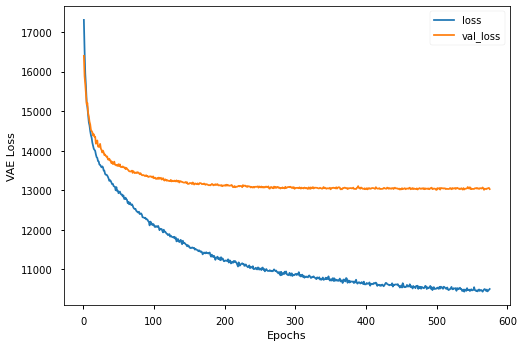

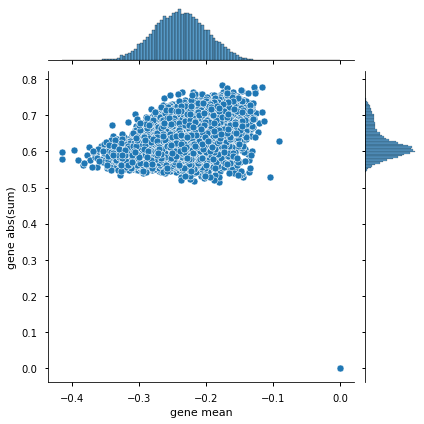

In [53]:
test_set_percent = 0.2
df2_test_df = df4_trans.sample(frac=test_set_percent)
df2_train_df = df4_trans.drop(df2_test_df.index)

# Set hyper parameters
original_dim = df4_trans.shape[1]
latent_dim = 100

epsilon_std = 1.0
beta = K.variable(0)
kappa = 1.0

def scheduler(epoch, lr):
    if epoch < 250:
        return lr
    else:
        return lr * tf.math.exp(-0.1)
def sampling(args):
    import tensorflow as tf
    # Function with args required for Keras Lambda function
    z_mean, z_log_var = args

    # Draw epsilon of the same shape from a standard normal distribution
    epsilon = K.random_normal(shape=tf.shape(z_mean), mean=0.,
                              stddev=epsilon_std)
    
    # The latent vector is non-deterministic and differentiable
    # in respect to z_mean and z_log_var
    z = z_mean + K.exp(z_log_var / 2) * epsilon
    return z

            
class CustomVariationalLayer(Layer):
    """
    Define a custom layer that learns and performs the training
    This function is borrowed from:
    https://github.com/fchollet/keras/blob/master/examples/variational_autoencoder.py
    """
    def __init__(self, **kwargs):
        # https://keras.io/layers/writing-your-own-keras-layers/
        self.is_placeholder = True
#         self.var_layer = var_layer
#         self.mean_layer = mean_layer
        super(CustomVariationalLayer, self).__init__(**kwargs)

    def vae_loss(self, x_input, x_decoded):
        #reconstruction_loss = original_dim * metrics.binary_crossentropy(x_input, x_decoded)
        reconstruction_loss = original_dim * metrics.mse(x_input, x_decoded)
        kl_loss = - 0.5 * K.sum(1 + z_log_var_encoded - K.square(z_mean_encoded) - 
                                K.exp(z_log_var_encoded), axis=-1)
        return K.mean(reconstruction_loss + (K.get_value(beta) * kl_loss))

    def call(self, inputs):
        x = inputs[0]
        x_decoded = inputs[1]
        loss = self.vae_loss(x, x_decoded)
        self.add_loss(loss, inputs=inputs)
        # We won't actually use the output.
        return x
    
class WarmUpCallback(Callback):
    def __init__(self, beta, kappa):
        self.beta = beta
        self.kappa = kappa
    # Behavior on each epoch
    def on_epoch_end(self, epoch, logs={}):
        if K.get_value(self.beta) <= 1:
            K.set_value(self.beta, K.get_value(self.beta) + self.kappa)

# Input place holder for RNAseq data with specific input size
rnaseq_input = Input(shape=(original_dim, ))

# Input layer is compressed into a mean and log variance vector of size `latent_dim`
# Each layer is initialized with glorot uniform weights and each step (dense connections,
# batch norm, and relu activation) are funneled separately
# Each vector of length `latent_dim` are connected to the rnaseq input tensor

#z_mean_dense_linear = Dense(latent_dim, kernel_initializer='glorot_uniform', kernel_regularizer=regularizers.L1L2(l1=l1_val, l2=l2_val))(rnaseq_input)
z_mean_dense_linear = Dense(latent_dim, kernel_initializer='glorot_uniform')(rnaseq_input)
z_mean_dense_batchnorm = BatchNormalization()(z_mean_dense_linear)
z_mean_encoded = Activation('relu')(z_mean_dense_batchnorm)

#z_log_var_dense_linear = Dense(latent_dim, kernel_initializer='glorot_uniform', kernel_regularizer=regularizers.L1L2(l1=l1_val, l2=l2_val))(rnaseq_input)
z_log_var_dense_linear = Dense(latent_dim, kernel_initializer='glorot_uniform')(rnaseq_input)
z_log_var_dense_batchnorm = BatchNormalization()(z_log_var_dense_linear)
z_log_var_encoded = Activation('relu')(z_log_var_dense_batchnorm)

# return the encoded and randomly sampled z vector
# Takes two keras layers as input to the custom sampling function layer with a `latent_dim` output
z = Lambda(sampling, output_shape=(latent_dim, ))([z_mean_encoded, z_log_var_encoded])

# The decoding layer is much simpler with a single layer and sigmoid activation

#decoder_to_reconstruct = Dense(original_dim, kernel_initializer='glorot_uniform', activation='sigmoid', kernel_regularizer=regularizers.L1L2(l1=l1_val, l2=l2_val))
decoder_to_reconstruct = Dense(original_dim, kernel_initializer='glorot_uniform', activation='sigmoid')
rnaseq_reconstruct = decoder_to_reconstruct(z)

learning_rate = 0.0005
adam = optimizers.Adam(lr=learning_rate)
vae_layer = CustomVariationalLayer()([rnaseq_input, rnaseq_reconstruct])
vae = Model(rnaseq_input, vae_layer)
vae.compile(optimizer=adam, loss=None, loss_weights=[beta])
schedule = tf.keras.callbacks.LearningRateScheduler(scheduler)
stopping = tf.keras.callbacks.EarlyStopping(monitor="val_loss",min_delta=0,patience=75,verbose=0,mode="auto",baseline=None,restore_best_weights=True,)

batch_size = 8
epochs = 10000

hist = vae.fit(np.array(df2_train_df),
               shuffle=True,
               epochs=epochs,
               verbose=1,
               batch_size=batch_size,
               validation_data=(np.array(df2_test_df), None),
               callbacks=[stopping, WarmUpCallback(beta, kappa)])#,
                          #TQDMCallback(verbose=2)])

# Visualize training performance
history_df = pd.DataFrame(hist.history).iloc[1:,:2]
hist_plot_file = os.path.join('images', 'df4_onehidden_training.pdf')
ax = history_df.plot()
ax.set_xlabel('Epochs')
ax.set_ylabel('VAE Loss')
fig = ax.get_figure()
fig.savefig(hist_plot_file)

encoder = Model(rnaseq_input, z_mean_encoded)

# Encode rnaseq into the hidden/latent representation - and save output
encoded_df2_trans = encoder.predict_on_batch(df4_trans)
encoded_df2_trans = pd.DataFrame(encoded_df2_trans, index=df4_trans.index)

encoded_df2_trans.columns.name = 'sample_id'
encoded_df2_trans.columns = encoded_df2_trans.columns + 1
encoded_file = os.path.join('data', 'encoded_df4_onehidden.csv')
encoded_df2_trans.to_csv(encoded_file)

# build a generator that can sample from the learned distribution
decoder_input = Input(shape=(latent_dim, ))  # can generate from any sampled z vector
_x_decoded_mean = decoder_to_reconstruct(decoder_input)
decoder = Model(decoder_input, _x_decoded_mean)

encoder_model_file = os.path.join('models', 'df4_encoder_onehidden_vae.hdf5')
decoder_model_file = os.path.join('models', 'df4_decoder_onehidden_vae.hdf5')

encoder.save(encoder_model_file)
decoder.save(decoder_model_file)

# How well does the model reconstruct the input RNAseq data
input_df2_trans_reconstruct = decoder.predict(np.array(encoded_df2_trans))
input_df2_trans_reconstruct = pd.DataFrame(input_df2_trans_reconstruct, index=df4_trans.index,
                                        columns=df4_trans.columns)
reconstruction_fidelity = df4_trans - input_df2_trans_reconstruct

gene_mean = reconstruction_fidelity.mean(axis=0)
gene_abssum = reconstruction_fidelity.abs().sum(axis=0).divide(df4_trans.shape[0])
gene_summary = pd.DataFrame([gene_mean, gene_abssum], index=['gene mean', 'gene abs(sum)']).T 
gene_summary.iloc[:,1].sum()/len(gene_summary.iloc[:,1])

g = sns.jointplot('gene mean', 'gene abs(sum)', data=gene_summary)
hist_plot_file = os.path.join('images', 'df4_onehidden_reconstruction_error.png')
g.savefig(hist_plot_file)

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Train on 240 samples, validate on 60 samples
Epoch 1/1000
192/240 [=======================>......] - ETA: 0s - loss: 17937.9281

/home/raghavgarg1000/miniconda3/envs/tybalt-gpu/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:2325: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


240/240 [==============================] - 1s 4ms/sample - loss: 17804.1138 - val_loss: 15363.2679
Epoch 2/1000
240/240 [==============================] - 0s 955us/sample - loss: 15935.4497 - val_loss: 14840.1361
Epoch 3/1000
240/240 [==============================] - 0s 959us/sample - loss: 15199.8753 - val_loss: 14725.7482
Epoch 4/1000
240/240 [==============================] - 0s 956us/sample - loss: 15027.4940 - val_loss: 14670.7621
Epoch 5/1000
240/240 [==============================] - 0s 941us/sample - loss: 14914.1984 - val_loss: 14562.0423
Epoch 6/1000
240/240 [==============================] - 0s 941us/sample - loss: 14794.1594 - val_loss: 14410.5523
Epoch 7/1000
240/240 [==============================] - 0s 941us/sample - loss: 14683.7332 - val_loss: 14356.3836
Epoch 8/1000
240/240 [==============================] - 0s 924us/sample - loss: 14612.1808 - val_loss: 14227.1821
Epoch 9/1000
240/240 [==============================] - 0s 955us/sample - loss: 14439.4332 - val_loss: 

240/240 [==============================] - 0s 936us/sample - loss: 12998.5927 - val_loss: 13074.0247
Epoch 73/1000
240/240 [==============================] - 0s 964us/sample - loss: 12981.0027 - val_loss: 13107.9865
Epoch 74/1000
240/240 [==============================] - 0s 955us/sample - loss: 12970.1706 - val_loss: 13064.4767
Epoch 75/1000
240/240 [==============================] - 0s 939us/sample - loss: 12967.6388 - val_loss: 13078.0022
Epoch 76/1000
240/240 [==============================] - 0s 966us/sample - loss: 12901.2862 - val_loss: 13063.8254
Epoch 77/1000
240/240 [==============================] - 0s 944us/sample - loss: 12950.0621 - val_loss: 13077.0590
Epoch 78/1000
240/240 [==============================] - 0s 919us/sample - loss: 12882.7558 - val_loss: 13071.6540
Epoch 79/1000
240/240 [==============================] - 0s 945us/sample - loss: 12979.3418 - val_loss: 13063.4471
Epoch 80/1000
240/240 [==============================] - 0s 942us/sample - loss: 12884.1223 - 

Epoch 143/1000
240/240 [==============================] - 0s 945us/sample - loss: 12244.5031 - val_loss: 12965.6518
Epoch 144/1000
240/240 [==============================] - 0s 946us/sample - loss: 12247.2726 - val_loss: 12988.6827
Epoch 145/1000
240/240 [==============================] - 0s 934us/sample - loss: 12263.9340 - val_loss: 12960.4184
Epoch 146/1000
240/240 [==============================] - 0s 933us/sample - loss: 12235.6267 - val_loss: 12986.9258
Epoch 147/1000
240/240 [==============================] - 0s 931us/sample - loss: 12221.6484 - val_loss: 12970.8332
Epoch 148/1000
240/240 [==============================] - 0s 917us/sample - loss: 12214.5362 - val_loss: 12978.3017
Epoch 149/1000
240/240 [==============================] - 0s 933us/sample - loss: 12176.3407 - val_loss: 12947.0423
Epoch 150/1000
240/240 [==============================] - 0s 926us/sample - loss: 12192.1370 - val_loss: 12988.3382
Epoch 151/1000
240/240 [==============================] - 0s 960us/sampl

240/240 [==============================] - 0s 926us/sample - loss: 11732.9872 - val_loss: 13015.4540
Epoch 214/1000
240/240 [==============================] - 0s 916us/sample - loss: 11710.7141 - val_loss: 13014.3736
Epoch 215/1000
240/240 [==============================] - 0s 892us/sample - loss: 11764.9971 - val_loss: 13001.5285
Epoch 216/1000
240/240 [==============================] - 0s 904us/sample - loss: 11704.8563 - val_loss: 12987.0598
Epoch 217/1000
240/240 [==============================] - 0s 944us/sample - loss: 11682.2421 - val_loss: 13006.3333
Epoch 218/1000
240/240 [==============================] - 0s 937us/sample - loss: 11665.3967 - val_loss: 12986.7671
Epoch 219/1000
240/240 [==============================] - 0s 929us/sample - loss: 11694.9354 - val_loss: 12976.0968
Epoch 220/1000
240/240 [==============================] - 0s 910us/sample - loss: 11660.5377 - val_loss: 12950.5872
Epoch 221/1000
240/240 [==============================] - 0s 891us/sample - loss: 11632

Epoch 284/1000
240/240 [==============================] - 0s 935us/sample - loss: 11272.7042 - val_loss: 13062.3139
Epoch 285/1000
240/240 [==============================] - 0s 919us/sample - loss: 11281.9985 - val_loss: 13075.6922
Epoch 286/1000
240/240 [==============================] - 0s 912us/sample - loss: 11289.1648 - val_loss: 13023.4040
Epoch 287/1000
240/240 [==============================] - 0s 936us/sample - loss: 11225.0587 - val_loss: 13033.1237
Epoch 288/1000
240/240 [==============================] - 0s 911us/sample - loss: 11321.7535 - val_loss: 13057.2215
Epoch 289/1000
240/240 [==============================] - 0s 913us/sample - loss: 11301.2880 - val_loss: 13060.0926
Epoch 290/1000
240/240 [==============================] - 0s 917us/sample - loss: 11255.5522 - val_loss: 13077.7620
Epoch 291/1000
240/240 [==============================] - 0s 910us/sample - loss: 11250.2190 - val_loss: 13043.8591
Epoch 292/1000
240/240 [==============================] - 0s 928us/sampl

240/240 [==============================] - 0s 914us/sample - loss: 10992.1798 - val_loss: 13127.1432
Epoch 355/1000
240/240 [==============================] - 0s 930us/sample - loss: 11046.4516 - val_loss: 13112.0963
Epoch 356/1000
240/240 [==============================] - 0s 925us/sample - loss: 10999.2951 - val_loss: 13102.7443
Epoch 357/1000
240/240 [==============================] - 0s 914us/sample - loss: 10955.0772 - val_loss: 13129.1885
Epoch 358/1000
240/240 [==============================] - 0s 916us/sample - loss: 11030.4836 - val_loss: 13160.0772
Epoch 359/1000
240/240 [==============================] - 0s 923us/sample - loss: 11012.8201 - val_loss: 13104.0832
Epoch 360/1000
240/240 [==============================] - 0s 923us/sample - loss: 10977.2411 - val_loss: 13095.7033
Epoch 361/1000
240/240 [==============================] - 0s 927us/sample - loss: 11017.2730 - val_loss: 13095.0510
Epoch 362/1000
240/240 [==============================] - 0s 908us/sample - loss: 10963

/home/raghavgarg1000/miniconda3/envs/tybalt-gpu/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:2325: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


0.6760389765513529


/home/raghavgarg1000/miniconda3/envs/tybalt-gpu/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


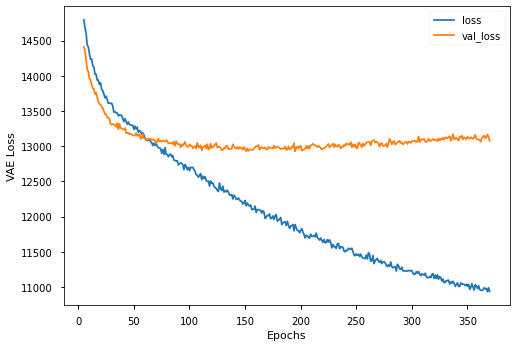

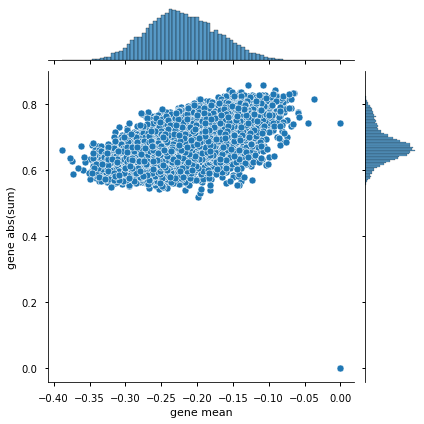

In [15]:
test_set_percent = 0.2
df2_test_df = df4_trans.sample(frac=test_set_percent)
df2_train_df = df4_trans.drop(df2_test_df.index)

# Set hyper parameters
original_dim = df4_trans.shape[1]
latent_dim = 100
hidden_dim = 100
epsilon_std = 1.0
beta = K.variable(0)
kappa = 1.0

def scheduler(epoch, lr):
    if epoch < 200:
        return lr
    else:
        return lr * tf.math.exp(-0.1)
def sampling(args):
    import tensorflow as tf
    # Function with args required for Keras Lambda function
    z_mean, z_log_var = args

    # Draw epsilon of the same shape from a standard normal distribution
    epsilon = K.random_normal(shape=tf.shape(z_mean), mean=0.,
                              stddev=epsilon_std)
    
    # The latent vector is non-deterministic and differentiable
    # in respect to z_mean and z_log_var
    z = z_mean + K.exp(z_log_var / 2) * epsilon
    return z

            
class CustomVariationalLayer(Layer):
    """
    Define a custom layer that learns and performs the training
    This function is borrowed from:
    https://github.com/fchollet/keras/blob/master/examples/variational_autoencoder.py
    """
    def __init__(self, **kwargs):
        # https://keras.io/layers/writing-your-own-keras-layers/
        self.is_placeholder = True
        super(CustomVariationalLayer, self).__init__(**kwargs)

    def vae_loss(self, x_input, x_decoded):
        #reconstruction_loss = original_dim * metrics.binary_crossentropy(x_input, x_decoded)
        reconstruction_loss = original_dim * metrics.mse(x_input, x_decoded)
        kl_loss = - 0.5 * K.sum(1 + z_log_var_encoded - K.square(z_mean_encoded) - 
                                K.exp(z_log_var_encoded), axis=-1)
        return K.mean(reconstruction_loss + (K.get_value(beta) * kl_loss))

    def call(self, inputs):
        x = inputs[0]
        x_decoded = inputs[1]
        loss = self.vae_loss(x, x_decoded)
        self.add_loss(loss, inputs=inputs)
        # We won't actually use the output.
        return x
    
class WarmUpCallback(Callback):
    def __init__(self, beta, kappa):
        self.beta = beta
        self.kappa = kappa
    # Behavior on each epoch
    def on_epoch_end(self, epoch, logs={}):
        if K.get_value(self.beta) <= 1:
            K.set_value(self.beta, K.get_value(self.beta) + self.kappa)

# Input place holder for RNAseq data with specific input size
rnaseq_input = Input(shape=(original_dim, ))

# Input layer is compressed into a mean and log variance vector of size `latent_dim`
# Each layer is initialized with glorot uniform weights and each step (dense connections,
# batch norm, and relu activation) are funneled separately
# Each vector of length `latent_dim` are connected to the rnaseq input tensor

hidden_dense_linear = Dense(hidden_dim, kernel_initializer='glorot_uniform')(rnaseq_input)
hidden_dense_batchnorm = BatchNormalization()(hidden_dense_linear)
hidden_encoded = Activation('relu')(hidden_dense_batchnorm)

z_mean_dense_linear = Dense(latent_dim, kernel_initializer='glorot_uniform')(hidden_encoded)
z_mean_dense_batchnorm = BatchNormalization()(z_mean_dense_linear)
z_mean_encoded = Activation('relu')(z_mean_dense_batchnorm)

z_log_var_dense_linear = Dense(latent_dim, kernel_initializer='glorot_uniform')(hidden_encoded)
z_log_var_dense_batchnorm = BatchNormalization()(z_log_var_dense_linear)
z_log_var_encoded = Activation('relu')(z_log_var_dense_batchnorm)

# return the encoded and randomly sampled z vector
# Takes two keras layers as input to the custom sampling function layer with a `latent_dim` output
z = Lambda(sampling, output_shape=(latent_dim, ))([z_mean_encoded, z_log_var_encoded])

# The decoding layer is much simpler with a single layer and sigmoid activation
decoder_model = keras.Sequential()
decoder_model.add(Dense(hidden_dim, activation='relu', input_dim=latent_dim))
decoder_model.add(Dense(original_dim, activation='sigmoid'))
rnaseq_reconstruct = decoder_model(z)

learning_rate = 0.0005
adam = optimizers.Adam(lr=learning_rate)
vae_layer = CustomVariationalLayer()([rnaseq_input, rnaseq_reconstruct])
vae = Model(rnaseq_input, vae_layer)
vae.compile(optimizer=adam, loss=None, loss_weights=[beta])
schedule = tf.keras.callbacks.LearningRateScheduler(scheduler)
stopping = tf.keras.callbacks.EarlyStopping(monitor="val_loss",min_delta=0,patience=175,verbose=0,mode="auto",baseline=None,restore_best_weights=True,)

batch_size = 8
epochs = 1000

hist = vae.fit(np.array(df2_train_df),
               shuffle=True,
               epochs=epochs,
               verbose=1,
               batch_size=batch_size,
               validation_data=(np.array(df2_test_df), None),
               callbacks=[stopping, WarmUpCallback(beta, kappa)])#,
                          #TQDMCallback(verbose=2)])

# Visualize training performance
history_df = pd.DataFrame(hist.history).iloc[5:,:2]
hist_plot_file = os.path.join('images', 'df4_twohidden100_training.pdf')
ax = history_df.plot()
ax.set_xlabel('Epochs')
ax.set_ylabel('VAE Loss')
fig = ax.get_figure()
fig.savefig(hist_plot_file)

encoder = Model(rnaseq_input, z_mean_encoded)

# Encode rnaseq into the hidden/latent representation - and save output
encoded_df = encoder.predict_on_batch(df4_trans)
encoded_df = pd.DataFrame(encoded_df, index=df4_trans.index)

encoded_df.columns.name = 'sample_id'
encoded_df.columns = encoded_df.columns + 1
encoded_file = os.path.join('data', 'encoded_df4_twohidden100.csv')
encoded_df.to_csv(encoded_file)

# build a generator that can sample from the learned distribution
decoder_input = Input(shape=(latent_dim, ))  # can generate from any sampled z vector
_x_decoded_mean = decoder_model(decoder_input)
decoder = Model(decoder_input, _x_decoded_mean)

encoder_model_file = os.path.join('models', 'df4_encoder_twohidden100_vae.hdf5')
decoder_model_file = os.path.join('models', 'df4_decoder_twohidden100_vae.hdf5')

encoder.save(encoder_model_file)
decoder.save(decoder_model_file)

# How well does the model reconstruct the input RNAseq data
input_df2_trans_reconstruct = decoder.predict(np.array(encoded_df))
input_df2_trans_reconstruct = pd.DataFrame(input_df2_trans_reconstruct, index=df4_trans.index,
                                        columns=df4_trans.columns)
reconstruction_fidelity = df4_trans - input_df2_trans_reconstruct

gene_mean = reconstruction_fidelity.mean(axis=0)
gene_abssum = reconstruction_fidelity.abs().sum(axis=0).divide(df4_trans.shape[0])
gene_summary = pd.DataFrame([gene_mean, gene_abssum], index=['gene mean', 'gene abs(sum)']).T
print(gene_summary.iloc[:,1].sum()/len(gene_summary.iloc[:,1]))

g = sns.jointplot('gene mean', 'gene abs(sum)', data=gene_summary)
hist_plot_file = os.path.join('images', 'df4_twohidden100_reconstruction_error.png')
g.savefig(hist_plot_file)